In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import time

from scipy.stats.mstats import gmean

rng = np.random.default_rng()

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
save_bool=False #save things?

N_boot=10000
N_samps = 10000
Nbins=500

N_samp = N_samps


col_arr = ['#2240FF','#00BF9F','#FFBB00','#f44336','#9e59b3'] #color array for soil taxa in the order: 'Acari','Collembola','Formicidae','Isoptera','Other'

### 1. Read the data

In [3]:
raw_data = pd.read_excel('data/RawData.xlsx')

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 2. Convert to dry weight

In [4]:
#correct the std for cases where the std is derived from the full reported range, as half this range
indx = ((raw_data['standard deviation']) == (raw_data['numerical value'])) & ((raw_data['standard deviation']) >0)
raw_data.loc[indx , 'standard deviation'] /= 2

#Correct units for dry weight using a general factor of 0.3
raw_data.loc[:,'norm value'] = raw_data.loc[:,'numerical value']
raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','norm value'] *= 0.3 # = raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','norm value']*0.3 #convert the wet mass to an effective dry mass, by multiplying by 0.3

raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','standard deviation'] *= 0.3 # = raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','standard deviation']*0.3 #convert the wet mass to an effective dry mass, by multiplying by 0.3 - for the std 
raw_data.loc[raw_data['standard deviation'].isna(),'standard deviation'] = 0

#change the convertion ratio for specific groups to be more accurate:
#Petersen & Luxton:
#Collembola - 0.32
#Acari - Cryptostigmata  0.4
#Isoptera - 0.27
#Formicodea - 0.228
#Araneae - 0.43
#Pseudoscorpiones  - 0.224
#Others - 0.3

# initialise data for correcting the conversion from wet to dry mass
conversion_rates = {'taxon':['Isoptera', 'Acari', 'Collembola', 'Formicidae','Araneae','Pseudoscorpiones'],
                     'rank':['super-family', 'sub-class','sub-class', 'family','order','order'],
                      'ratio':[0.27, 0.4,0.32,0.228,0.43,0.224]}
 
convR = pd.DataFrame(conversion_rates)

for ii in convR.index:
    case = pd.concat([raw_data[convR.loc[ii,'rank']]==convR.loc[ii,'taxon'], raw_data.units=='mg/m^2 (wet weight)'], axis=1).all(axis=1)
    raw_data.loc[case,'norm value']= raw_data.loc[case,'numerical value']*convR.loc[ii,'ratio'] 
    raw_data.loc[case,'standard deviation'] *= convR.loc[ii,'ratio'] /0.3


#units type distinguishes population to biomass measurements
def unit_type(x):
    X=x.partition('/')[0]
    return X

raw_data.loc[:,'units type'] = raw_data.units.apply(unit_type) #units type distinguishes population to biomass measurements

raw_data.groupby('units type').site.nunique()#display the counts for the separated data

units type
individuals    325
mg             388
Name: site, dtype: int64

### 3. Remove partial measurements, and those with unknown biomes

In [5]:
metadata = pd.read_csv('data/groups_per_reference.csv')
data_with_meta = raw_data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [6]:
valid_data = data_with_meta.copy()
valid_data = valid_data[(valid_data['Standard groups']!='Microarthropods') | ((valid_data['Standard groups']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])) & (valid_data['aggregated environment'] =='soil/litter') )]
valid_data = valid_data[(valid_data['studied group']!='Microarthropods') | ((valid_data['studied group']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])) & (valid_data['aggregated environment'] =='soil/litter') )]#basically the same filtering

#Drop the ants measurements with unknown biomes
valid_data = valid_data[valid_data['aggregated biome'] != 'Shrubland/Grassland']

### 4. Classify into taxonomic and habitat type groups

In [7]:
valid_data.loc[valid_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
valid_data.loc[valid_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
valid_data.loc[valid_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
valid_data.loc[valid_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
valid_data.loc[valid_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

valid_data.loc[valid_data['aggregated environment'] !='soil/litter','aggregated taxon'] = 'Combined'

In [8]:
soil_data = valid_data[valid_data['aggregated environment'] =='soil/litter']
above_ground_data = valid_data[valid_data['aggregated environment'] !='soil/litter'] #Canopy data for forested biomes, and surface dwelling and other plants related arthropods otherwise. Canopies in non-forested areas are undersampled.

In [9]:
canopy_data = valid_data[valid_data['aggregated environment'] =='plants']
canopy_data.groupby('aggregated biome').site.nunique()

Series([], Name: site, dtype: int64)

### 5. Sum and average over taxa per site, and calculate the effective mass of an individual soil arthropod

In [10]:
#Average the soil data over each taxon in each site, then sum all taxons in each site according to the aggregated groups and data type they are in.
soil_site_taxa_mean = soil_data.groupby(['units type','aggregated taxon','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
soil_site_data = soil_site_taxa_mean.groupby(['units type','aggregated taxon','aggregated biome','site'])['norm value'].sum().reset_index()

#Divide into the two types of measurements
soil_site_data_pop = soil_site_data[soil_site_data['units type']=='individuals']
soil_site_data_pop.rename(columns={'norm value': 'population density'}, inplace=True)

soil_site_data_mass = soil_site_data[soil_site_data['units type']=='mg']
soil_site_data_mass.rename(columns={'norm value': 'mass density'}, inplace=True)

#Construct a new dataframe, where we keep only the sites with both measurement types
soil_site_data_comb = pd.merge( soil_site_data_pop, soil_site_data_mass, on=["aggregated taxon","aggregated biome","site"], how="inner", validate="one_to_one" )

#calculate the mass of an individual per site, in units of mg/ind
soil_site_data_comb.loc[:,'ind mass']=soil_site_data_comb.loc[:,'mass density']/soil_site_data_comb.loc[:,'population density']

#Present the mass of an individual per biome and taxon, in units of mg/ind
##soil_site_data_comb.pivot_table(index='aggregated taxon',columns='aggregated biome',values='ind mass', aggfunc=['mean','count'])

print('Number of sites with combined data: ' + '%d' %soil_site_data_comb.site.nunique())

Number of sites with combined data: 191


/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
#filter out outliers for the effective mass of an individuals
def filter_outliers(x):
    if len(x)>3:
        STD=x.std()
        Mean=np.mean(x)
        x = x[x<(Mean+2*STD)]
        x = x[x>(Mean-2*STD)]
    return x

soil_ratio_filt = soil_site_data_comb.groupby(['aggregated taxon','aggregated biome'])['ind mass'].apply(filter_outliers)
soil_ratio_filt_full = soil_ratio_filt.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='ind mass', aggfunc='mean')
soil_ratio_filt_total = soil_ratio_filt.reset_index().groupby('aggregated taxon')['ind mass'].mean() #the global mean for the mass ratio per taxon
soil_ratio_filt_full = pd.merge(soil_ratio_filt_full, soil_ratio_filt_total,on="aggregated taxon", how="inner", validate="one_to_one" )
soil_ratio_filt_full.rename(columns={'ind mass': 'Total average (mg/ind)'}, inplace=True)

#fill in the nans with the global averages and save to csv
for clm in soil_ratio_filt_full.columns:
    soil_ratio_filt_full.loc[soil_ratio_filt_full[clm].isnull(),clm] = soil_ratio_filt_full['Total average (mg/ind)']

biomes = soil_site_data_pop.loc[:,'aggregated biome'].unique()

for biom in biomes: 
    if biom not in soil_ratio_filt_full.columns:
        soil_ratio_filt_full.loc[:,biom] = soil_ratio_filt_full.loc[:,'Total average (mg/ind)']

if save_bool:        
    soil_ratio_filt_full.to_csv('results/tables/average_ind_mass_full.csv')##       

def print_ratio(x):
    return '{:.2e}'.format(x)

soil_ratio_filt_print = soil_ratio_filt_full.applymap(print_ratio)
#soil_ratio_filt_print.to_csv('results/table_average_ind_mass.csv')## #~~ export rounded values

#present soil_ratio_filt_print
#soil_ratio_filt_full.applymap(print_ratio)##



### 6. Define all functions for the bootstrapping process

In [12]:
#Bootstrap using random choose with replacement. returns an array of means
def Boot_means(vals, sigma,Boot_N):
    L = len(vals)
    means = np.zeros(Boot_N) 

    for ii in range(Boot_N): #random choose with replacement
        indx = rng.choice(np.array(range(L)),L, replace=True)

        Boot = np.zeros(L)
        jj=0
        for ind in indx: #add the measurement uncertainties using a normal distribution
            Boot[jj] = np.max( [ 0 , rng.normal(vals[ind], sigma[ind], 1) ])
            jj +=1
        
        means[ii] = np.mean(Boot) #take the mean of a single resample
    
    return means

In [13]:
#Define functions for bootstrapping and data preparation

#~~~ Think how to improve the cdf function to reduce the effects of bin position and number of bins. Perhaps using a kde?
#define default parameters
#N_boot=10000
#N_samps = 10000
#Nbins=500

#Get the aggregated biome areas
biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum().reset_index().rename(columns={'aggregated biome 1': 'aggregated biome'}) #aggregate the biomes areas

def sum_error(x):
    return np.sqrt(np.sum(x**2))

def mean_error(x):
    return sum_error(x)/np.sqrt(len(x))

#Average the soil data over each taxon in each site, then sum all taxons in each site according to the aggregated groups and data type they are in.
def averaged_sum_site(data,GroupBy=['aggregated taxon','aggregated biome']):
    GroupBy = GroupBy + ['site','taxon']

    data_taxa_mean = data.groupby(GroupBy)['norm value'].mean().reset_index() # mean per taxon and site in each group
    data_site = data_taxa_mean.groupby(GroupBy[:-1])['norm value'].sum().reset_index() # sum over all taxa in each site for each group
    
    data_taxa_mean_std = data.groupby(GroupBy)['standard deviation'].apply(mean_error).reset_index() # mean per taxon and site in each group
    data_site_std = data_taxa_mean_std.groupby(GroupBy[:-1])['standard deviation'].apply(sum_error).reset_index() # sum over all taxa in each site for each group

    return data_site.merge(data_site_std)

#get bootstrapped means using pandas
def boot_means2(x,N): 
    means=np.zeros(N)
    for ii in range(N):
        smp = x.sample(frac=1, replace=True, weights=None, random_state=None, axis=None).iloc[:,[-2,-1]]
        rnds = rng.normal(smp.iloc[:,0].values,smp.iloc[:,1].values)
        rnds[rnds<0]=0
        means[ii]=np.mean(rnds)

    return means

#Extract mean and 95% CI from bootstrapped data (returns an array)
def Boot_stats(means, prcnt_low=2.5, prcnt_high=97.5):    
    Mean = np.mean(means)
    prcnt = np.percentile(means,[prcnt_low,prcnt_high])
    return np.array([Mean , prcnt[0], prcnt[1]])


#Functions that help to handel the bootstrapped data and help in the Monte Carlo process for the total sum
def means_to_cdf(means, Nbins=Nbins): #converts the means array into a descrete cdf (cumulative distribution function) using a histogram with Nbins bins. 
    hist, bin_edges = np.histogram(means, bins = Nbins, density = False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:] )/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    return cdf, bin_centers

#bootstrap and return compressed results using pandas
def boot(data,GroupBy=['aggregated taxon','aggregated biome'],N=N_boot): 
    means = data.groupby(GroupBy).apply(lambda x: pd.Series(boot_means2(x,N),index=range(N))) #generate means array for each group
    Stats = means.apply(lambda x: pd.Series(Boot_stats(x),index=['mean','2.5%','97.5%']) ,axis=1) #extract stats from these arrays
    CDF = means.apply(lambda x: pd.Series(means_to_cdf(x),index=['cdf','values']),axis=1) #Extract a cumulative distribution function for Monte-Carlo etc.
    return Stats, CDF

def random_from_cdf(cdf,bin_centers,N): #picks N values of bin_centers according to the histogram's cdf
    values = np.random.rand(N)
    value_bins_indx = np.searchsorted(cdf, values)
    rnd_from_cdf = bin_centers[value_bins_indx]
    return rnd_from_cdf

#Get global (biome-level) stats from the density stats
def dens_2_tot(Stats,area=biome_area1):
    biome_means = Stats.reset_index().merge(area)
    biome_means.loc[:,'Total'] = (biome_means.loc[:,'mean']*biome_means.loc[:,'area']).values/1e15 #total biomass per biome, in units of Mt
    biome_means.loc[:,'Total_low'] = (biome_means.loc[:,'2.5%']*biome_means.loc[:,'area']).values/1e15 #total low biomass per biome, in units of Mt
    biome_means.loc[:,'Total_high'] = (biome_means.loc[:,'97.5%']*biome_means.loc[:,'area']).values/1e15 #total high biomass per biome, in units of Mt
    return biome_means

#Convert CDF to absolute units (from density to absolute in each biome), and sum using a Monte-Carlo process
def cdf_2_tot(CDF,area=biome_area1, N_samps = N_samps): #area is a pd.DataFrame, N_samps = number of samples used for each taxon-biome CDF

    area = pd.DataFrame(area).set_index('aggregated biome')
    dist_tot = CDF.merge(area,left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes 
    dist_tot.loc[:,'values'] = (dist_tot['values']*dist_tot['area'])
    dist_tot.drop('area',axis='columns',inplace=True)
    samps_dist_tot = dist_tot.apply(lambda x: pd.Series(random_from_cdf(x['cdf'],x['values'],N_samps),index=range(N_samps)),axis=1)
    return samps_dist_tot/1e15

#combine total biomass means of several habitats (called x,y,z)
def comb_tots(x,y,N_samps=N_samps,Nbins=Nbins):
    combined = pd.DataFrame(columns=['cdf','tots'])
    ii=0
    for habitat in [x,y]:
        cdf, tots = means_to_cdf(habitat, Nbins)
        combined.loc[ii,:]=[[cdf], [tots]]
        ii+=1
    combined = combined.apply(lambda x: pd.Series(random_from_cdf(x['cdf'][0],x['tots'][0],N_samps),index=range(N_samps)),axis=1)
    return combined.sum()
    

In [14]:
#Split data according to unit type (mass or popiulation) and use mass of individuals to convert all to mass
def average_with_eff_mass(data,GroupBy=['units type','aggregated taxon','aggregated biome']):
    
    x = averaged_sum_site(data,GroupBy)

    #Divide into the two types of measurements
    x_pop = x[x['units type']=='individuals']
    x_pop.rename(columns={'norm value': 'population density','standard deviation': 'pop_std'}, inplace=True)

    x_mass = x[x['units type']=='mg']
    x_mass.rename(columns={'norm value': 'mass density','standard deviation': 'mass_std'}, inplace=True)

    #Construct a new dataframe, where we keep only the sites with both measurement types
    x_comb = pd.merge( x_pop, x_mass, on=GroupBy[1:]+['site'], how="inner", validate="one_to_one" ) #used to be: on=["aggregated taxon","aggregated biome","site"]

    #find the measurements where only population data is available
    cond1 = x_pop['site'].isin(x_comb['site']) #intersection of cond1 and cond2 will be excluded
    cond2 = x_pop['population density'].isin(x_comb['population density']) 
    x_pop_pure = x_pop.drop(x_pop[cond1 & cond2].index )#measurements with only population measurements, and no mass measurements, based on site name and numerical value    
    
    #read the weight of an individual taxon in each biome, and also globaly
    soil_ratio_filt_full = pd.read_csv('results/tables/average_ind_mass_full.csv').set_index('aggregated taxon')##         
    
    
    #convert population to effective mass based on biome level (_B) or global level (_G)
    def to_mass_B(x_pop_pure,ind_mass = soil_ratio_filt_full):
        if x_pop_pure.loc['aggregated taxon'] != 'Other': #We don't calculate an effective mass for 'Others', as this group is too diverse
            return x_pop_pure.loc[['population density','pop_std']]* ind_mass.loc[x_pop_pure.loc['aggregated taxon'],x_pop_pure.loc['aggregated biome']]
        else:
            return np.nan

    def to_mass_G(x_pop_pure,ind_mass = soil_ratio_filt_full):
        if x_pop_pure.loc['aggregated taxon'] != 'Other': #We don't calculate an effective mass for 'Others', as this group is too diverse
            return x_pop_pure.loc[['population density','pop_std']]* ind_mass.loc[x_pop_pure.loc['aggregated taxon'],'Total average (mg/ind)']
        else:
            return np.nan

        
    X = x_pop_pure.apply(to_mass_B,axis=1)
    X.rename(columns={'population density':'eff_mass_B','pop_std':'eff_mass_std_B'}, inplace=True)
    x_pop_pure = x_pop_pure.join(X)
    
    X = x_pop_pure.apply(to_mass_G,axis=1)
    X.rename(columns={'population density':'eff_mass_G','pop_std':'eff_mass_std_G'}, inplace=True)
    x_pop_pure = x_pop_pure.join(X)
        
    #Merge all the measurements, converted into mass
    x_mass_all = pd.merge(x_mass,x_pop_pure,on=GroupBy[1:]+['site'], how="outer") #used to be: on=["aggregated taxon","aggregated biome","site"]

    x_mass_all.loc[:,'mass_B'] = x_mass_all.loc[:,['mass density','eff_mass_B']].apply(np.nansum,axis=1)
    x_mass_all.loc[:,'mass_B_std'] = x_mass_all.loc[:,['mass_std','eff_mass_std_B']].apply(np.nansum,axis=1)
    x_mass_all.loc[:,'mass_G'] = x_mass_all.loc[:,['mass density','eff_mass_G']].apply(np.nansum,axis=1)
    x_mass_all.loc[:,'mass_G_std'] = x_mass_all.loc[:,['mass_std','eff_mass_std_G']].apply(np.nansum,axis=1)

    x_mass_all = x_mass_all[~np.isnan(x_mass_all.loc[:,'mass_G'])] # remove measurements of "other" taxa where there is no direct biomass measurement

    return x_mass_all


In [15]:
#printing functions:
def prtF(x):#print format
    return '{:.0f}'.format(x)

def prnt_monte(Overall_tots):
    return 'Median: ' + prtF(Overall_tots.median()) +' (95% CI:'+ prtF(np.percentile(Overall_tots,[2.5])[0]) +'-'+ prtF(np.percentile(Overall_tots,[97.5])[0]) +') Mt'

def prnt_stats(tots):
    return 'Mean: ' + prtF(tots.Total.sum()) +' (Range:'+ prtF(tots.Total_low.sum()) +'-'+ prtF(tots.Total_high.sum()) +') Mt'

#for population data:
def prtF_pop(x):#print format 
    return '{:.1e}'.format(x)

def prnt_monte_pop(Overall_tots):
    return 'Median: ' + prtF_pop(Overall_tots.median()) +' (95% CI:'+ prtF_pop(np.percentile(Overall_tots,[2.5])[0]) +'-'+ prtF_pop(np.percentile(Overall_tots,[97.5])[0]) +') individuals'

def prnt_stats_pop(tots):
    return 'Mean: ' + prtF_pop(tots.Total.sum()) +' (Range:'+ prtF_pop(tots.Total_low.sum()) +'-'+ prtF_pop(tots.Total_high.sum()) +') individuals'

In [16]:
def plot_biomass(Overall_tots, color='b', xlabel = 'Total Dry Biomass [Mt]',
                 ylabel='Probability Density\n[arb. units]', save_bool = False, filename='test',title='',norm_to_1=True, show=True):
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
#    plt.figure()
    plt.hist(Overall_tots,bins=200,alpha=1,color=color)
    
    if norm_to_1:
        ax = plt.gca()
        mx= ax.get_ylim()[1]*0.95 #np.max(np.histogram(Overall_tots,bins=200)[0])
        ax.yaxis.set_ticks([0, mx/2, mx])
        ax.yaxis.set_ticklabels([0, 0.5, 1])
    
    plt.xlabel(xlabel,size = 18)
    plt.ylabel(ylabel,size = 18)
    plt.title(title,size = 20)

    xc = np.percentile(Overall_tots,[2.5,50,97.5])
    plt.axvline(x=xc[0], color='k', linestyle='--',alpha=0.5, label = '2.5%')
    plt.axvline(x=xc[1], color='r', linestyle='-',alpha=0.7, label = 'Median')
    plt.axvline(x=xc[2], color='k', linestyle='--',alpha=0.5, label = '97.5%')
    
    plt.tight_layout()
    plt.legend(loc='upper right')
    
    if save_bool:
        plt.savefig('results/figs/png/' + filename + '.png',dpi=300) ##
        plt.savefig('results/figs/svg/' + filename + '.svg',dpi=300) ##
        plt.savefig('results/figs/' + filename + '.pdf',dpi=300)
    else:
        if show:
            plt.show()
        
Habitat_Color=['#945200','#FFD479','#008F00'] 

### 7. Calculate biomasses using bootstrapping

Total soil biomass from Stats (extended range): 
Mean: 222 (Range:102-397) Mt
Total soil biomass from Monte-Carlo: 
Median: 221 (95% CI:186-262) Mt


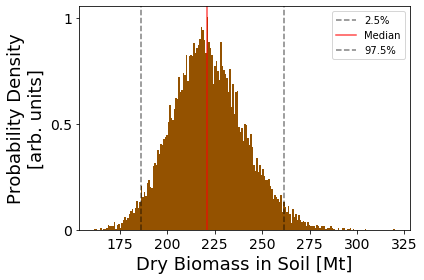

In [17]:
#N_boot=10000
#N_samp=10000
#Nbins=500

#Soil: 
soil_site_data_mass_all = average_with_eff_mass(soil_data,GroupBy=['units type','aggregated taxon','aggregated biome']) #data to be used. Contains all soil data, converted into dry biomass
soil_Stats, CDF = boot(soil_site_data_mass_all,GroupBy=['aggregated taxon','aggregated biome'],N=N_boot)
soil_tots = dens_2_tot(soil_Stats,area=biome_area1)
print('Total soil biomass from Stats (extended range): \n' + prnt_stats(soil_tots))

samp_dist_tots = cdf_2_tot(CDF,area=biome_area1, N_samps = N_samp)
soil_Overall_tots = samp_dist_tots.sum(axis=0)
print("Total soil biomass from Monte-Carlo: \n"+ prnt_monte(soil_Overall_tots))

plot_biomass(soil_Overall_tots,color=Habitat_Color[0], xlabel = 'Dry Biomass in Soil [Mt]', ylabel='Probability Density\n[arb. units]',
             save_bool = save_bool , filename='Soil Biomass')

#col_arr = ['#4285F4','#00A88C','#FFBB00','#f44336','#9e59b3']#~~~

tot_biomass_taxon = samp_dist_tots.groupby('aggregated taxon').sum().T

In [18]:
def round_significant_N(x,N): #round the number to N significant digits
    if x!=0:
        x_pos = np.abs(x)
        digits = int(np.floor(np.log10(x_pos))+1) #number of digits before the decimal point in x
        decimals = -(digits-N) #number of decimals in the final result
        X = np.round(x, decimals)

        if decimals<1: #convert to an integer if possible
            X=int(X)
    else: 
        X=int(0)
    return X

def print_export(mean,low,high,N_sites,N=2): #print the mean and range (low-high) rounded to N significant digits, for exporting data tables
    mean = round_significant_N(mean,N)
    low = round_significant_N(low,N)
    high = round_significant_N(high,N)
    
    txt='{MEAN} ({LOW}-{HIGH})\nN = {N_SITES}'
    return txt.format(MEAN=mean, LOW=low, HIGH=high, N_SITES=int(N_sites))

In [19]:
soil_export = soil_Stats.reset_index().merge(soil_site_data_mass_all.groupby(['aggregated taxon','aggregated biome']).site.count().reset_index())
soil_export = soil_export.groupby(['aggregated taxon','aggregated biome']).mean()
soil_export = soil_export.apply(lambda x : print_export(x['mean'], x['2.5%'],x['97.5%'],x['site'],N=1),axis=1).reset_index()
soil_export.rename(columns={'aggregated taxon' : 'Aggregated Taxon', 'aggregated biome': 'Aggregated Biome',0: 'Density (95% Range)', 'site': '# Sites'}, inplace=True)
soil_density_table = pd.pivot(soil_export, values=['Density (95% Range)'], index='Aggregated Biome',
                    columns='Aggregated Taxon')

if save_bool:
    soil_density_table.to_csv('results/tables/Soil density table.csv')

N_soil_meas=soil_site_data_mass_all.groupby(['aggregated taxon','aggregated biome']).site.count()
N_soil_meas.index
#soil_Stats.merge(soil_site_data_mass_all.groupby(['aggregated taxon','aggregated biome']).site.count())
isequal(soil_Stats.index,

Total above ground biomass from Stats (extended range): 
Mean: 54 (Range:21-105) Mt
Total above ground biomass from Monte-Carlo: 
Median: 52 (95% CI:29-89) Mt


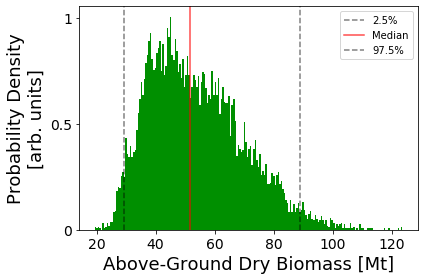

In [20]:
#Above ground:
above_ground_data_mass = above_ground_data[above_ground_data['units type']=='mg']

above_ground_data_site = averaged_sum_site(above_ground_data_mass,GroupBy=['aggregated biome'])
above_ground_Stats, CDF = boot(above_ground_data_site,GroupBy=['aggregated biome'],N=N_boot)
above_ground_tots = dens_2_tot(above_ground_Stats,area=biome_area1)
print('Total above ground biomass from Stats (extended range): \n' + prnt_stats(above_ground_tots))

samp_dist_tots = cdf_2_tot(CDF,area=biome_area1, N_samps = N_samp)
above_ground_Overall_tots = samp_dist_tots.sum(axis=0)
print("Total above ground biomass from Monte-Carlo: \n"+ prnt_monte(above_ground_Overall_tots))

plot_biomass(above_ground_Overall_tots,color=Habitat_Color[2], xlabel = 'Above-Ground Dry Biomass [Mt]', ylabel='Probability Density\n[arb. units]',
             save_bool = save_bool , filename='Above-Ground Biomass')

In [21]:
above_ground_tots

,aggregated biome,mean,2.5%,97.5%,area,Total,Total_low,Total_high
0,Boreal Forests/Taiga,153.877272,127.053333,201.240000,1.570000e+13,2.415873,1.994737,3.159468
1,Crops,132.972830,91.356289,182.755839,1.530000e+13,2.034484,1.397751,2.796164
2,Deserts and Xeric Shrublands,400.128118,18.793107,774.494520,1.960000e+13,7.842511,0.368345,15.180093
3,"Mediterranean Forests, Woodlands and Scrub",218.418000,218.418000,218.418000,1.620000e+12,0.353837,0.353837,0.353837
4,Pasture,144.673755,24.170797,358.725432,2.760000e+13,3.992996,0.667114,9.900822
5,Temperate Forests,118.133839,47.380000,202.448175,1.076000e+13,1.271120,0.509809,2.178342
6,"Temperate Grasslands, Savannas and Shrublands",174.370310,84.469769,265.910608,5.430000e+12,0.946831,0.458671,1.443895
7,Tropical and Subtropical Forests,1516.957589,484.236233,3438.575492,1.764300e+13,26.763683,8.543380,60.666787
8,"Tropical and Subtropical Grasslands, Savannas ...",786.252181,687.333333,942.520000,1.040000e+13,8.177023,7.148267,9.802208


Overall_biomass
Median: 275 (95% CI:231-328) Mt
Range: 124 - 502 Mt


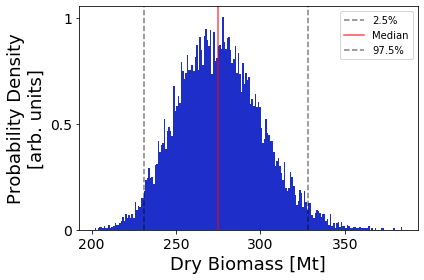

In [22]:
#Total biomass:
Overall_biomass = comb_tots(soil_Overall_tots,above_ground_Overall_tots,N_samps=N_samp,Nbins=Nbins)
print('Overall_biomass\n'+ prnt_monte(Overall_biomass))

Overall_low = soil_tots.Total_low.sum()+above_ground_tots.Total_low.sum()
Overall_high = soil_tots.Total_high.sum()+above_ground_tots.Total_high.sum()
print('Range: ' + prtF(Overall_low) + ' - ' + prtF(Overall_high) + ' Mt')

plot_biomass(Overall_biomass,color='#1e2fc9', xlabel = 'Dry Biomass [Mt]', ylabel='Probability Density\n[arb. units]',
             save_bool = save_bool , filename='All Biomass')

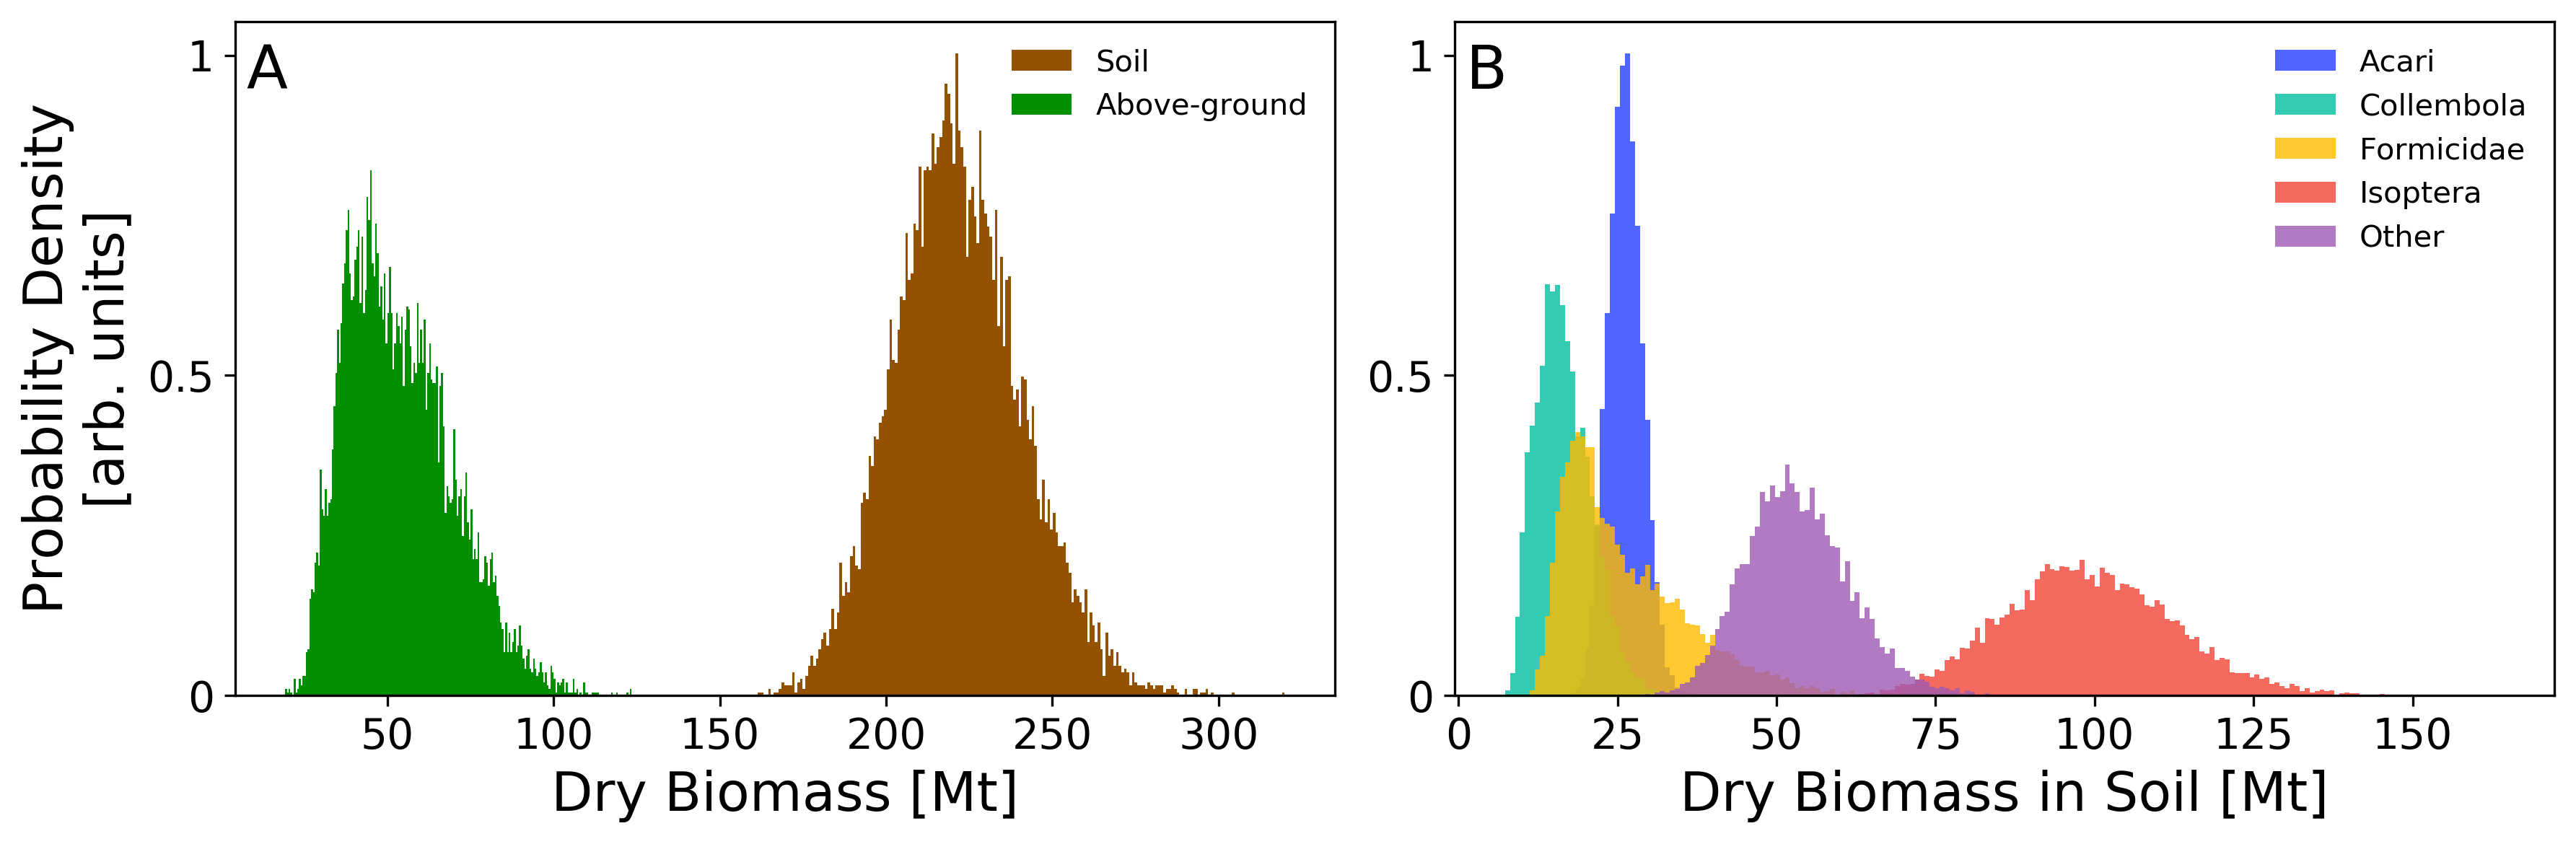

In [23]:
#Save plots.
fig,ax = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax = plt.subplot(1,2,1)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

def plot_biomass_comb(Overall_tots, xlabel = 'Dry Biomass [Mt]', ylabel='Probability Density\n[arb. units]',color='b',log=False,alpha=1):
    if log:
        plt.xscale('log')
    
    plt.hist(Overall_tots,bins=200,alpha=alpha, color=color)

    plt.xlabel(xlabel,size = 18)
    plt.ylabel(ylabel,size = 18)

Habitat_Color=['#945200','#FFD479','#008F00'] 
#plt.figure()        
plot_biomass_comb(soil_Overall_tots,color=Habitat_Color[0])
plot_biomass_comb(above_ground_Overall_tots,color=Habitat_Color[2])

mx=ax.get_ylim()[1]*0.95 #np.max(np.histogram(above_ground_Overall_tots,bins=200)[0])
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'A',fontdict={'size':20},transform = ax.transAxes)

plt.legend(['Soil','Above-ground'],frameon=False)
#plt.tight_layout()
#plt.show()

#if save_bool:
#    plt.savefig('results/figs/png/Habitats_biomass.png',dpi=300) ##
#    plt.savefig('results/figs/Habitats_biomass.pdf',dpi=300)

ax = plt.subplot(1,2,2)

def plot_taxa_biomass(tot_biomass_taxon, ax=ax, xlabel = 'Total Dry Biomass [Mt]', ylabel='Probability Density\n[arb. units]', save_bool = False, filename='test',log=False):
    
#    col_arr = ['#4285F4','#00A88C','#FFBB00','#f44336','#9e59b3'] #7CBB00~~~
        
    tot_biomass_taxon.plot.hist(bins=200, ax=ax, alpha=0.8,color=col_arr,log=log)
    if log:
        plt.gca().set_xscale("log")

    plt.xlabel(xlabel,size = 18)
    plt.ylabel(ylabel,size = 18)
#    plt.tight_layout()
    if save_bool:
        plt.savefig('results/figs/png/' + filename + '.png',dpi=300) ##
        plt.savefig('results/figs/svg/' + filename + '.svg',dpi=300) ##
        plt.savefig('results/figs/' + filename + '.pdf',dpi=300)
#    else:
#        plt.show()
        

plot_taxa_biomass(tot_biomass_taxon, xlabel = 'Dry Biomass in Soil [Mt]', ylabel='' , save_bool = False , filename='Soil Dry Biomass (taxa)')

ax.legend(title='',frameon=False)

mx=ax.get_ylim()[1]*0.95 #np.max(np.histogram(tot_biomass_taxon,bins=200)[0])*0.75
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'B',fontdict={'size':20},transform = ax.transAxes)

plt.tight_layout()
#if save_bool:
#    plt.savefig('results/figs/Biomass distributions.pdf',dpi=300)
plt.show()

8. Prepare plot and read data for termites

In [24]:
def legend_without_duplicate_labels(ax,pos):
    handles, labels = ax.get_legend_handles_labels()
    mapping = [ ['Acari', 'Acari (Mites)    '],['Collembola', 'Collembola (Springtails)    '],['Formicidae','Formicidae (Ants)    '],['Isoptera', 'Isoptera (Termites)    '],['Other','Others']]
    labels2 = [x.replace(subM[0], subM[1]) for x in labels for subM in mapping if subM[0] in x]
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels2)) if l not in labels2[:i]]
    unique = [unique[0],unique[1],unique[2], unique[3], unique[4]]      ## can be removed
    ax.legend(*zip(*unique),bbox_to_anchor=pos,loc = 'upper center', ncol=5,frameon=False)


In [25]:
Isoptera_data = pd.read_excel('data/IsopteraData.xlsx')

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


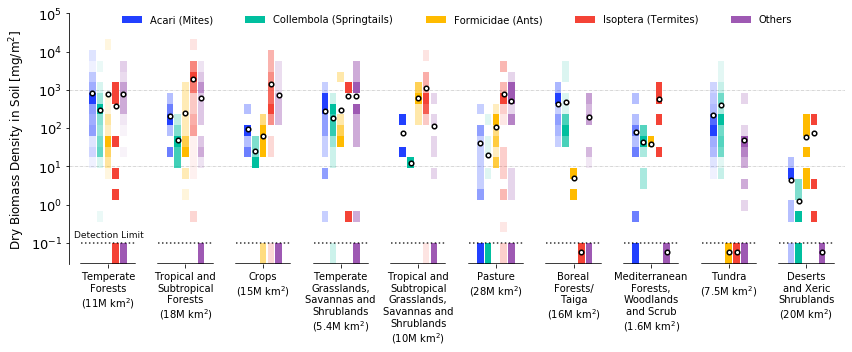

In [105]:
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=False)

#r is the data to be plotted
r = soil_site_data_mass_all.reset_index().rename(columns={'mass_G':'numerical value'}) #'numerical value' is the column being used later

#Sort according to biomes total mean biomass, in a descending order
sorter = soil_Stats.reset_index().groupby('aggregated biome').sum().sort_values(by='mean',ascending=False).index
sorterIndex = dict(zip(sorter, range(len(sorter))))
r['sorting_biomes'] = r['aggregated biome'].map(sorterIndex)
r.sort_values(['sorting_biomes'],ascending = True, inplace = True)
r.drop('sorting_biomes', 1, inplace = True)

original_biomes = r['aggregated biome'].unique()
transdict = {'Boreal Forests/Taiga': 'Boreal\nForests/\nTaiga\n(16M km$^2$)',
             'Crops':'Crops\n(15M km$^2$)',
             'Deserts and Xeric Shrublands':'Deserts\nand Xeric\nShrublands\n(20M km$^2$)',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean\nForests,\nWoodlands\nand Scrub\n(1.6M km$^2$)',
             'Pasture':'Pasture\n(28M km$^2$)',
           'Temperate Forests':'Temperate\nForests\n(11M km$^2$)',
           'Temperate Grasslands, Savannas and Shrublands':'Temperate\nGrasslands,\nSavannas and\nShrublands\n(5.4M km$^2$)',
           'Tropical and Subtropical Forests':'Tropical and\nSubtropical\nForests\n(18M km$^2$)',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands\n(10M km$^2$)',
           'Tundra':'Tundra\n(7.5M km$^2$)'
            }

print_biomes = [transdict[biome] for biome in original_biomes]
r.replace(to_replace=original_biomes,value=print_biomes,inplace=True)

bins = np.logspace(-1,np.log10(r['numerical value'].max()),20)
bins = np.insert(bins,0,-0.1) #add the point -0.1 to the beginning of the bins array
  
t = r.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index() #how many in each bin
t_max = t.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(np.max).reset_index() 
t_norm = t.merge(t_max,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon']) #normalize to the maximal bin value
t_norm['val'] = t_norm['numerical value_x']/t_norm['numerical value_y']


Isoptra = Isoptera_data.replace(to_replace=original_biomes,value=print_biomes)


fig,ax=plt.subplots(figsize=[12,5]) #[11,4])

fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
#col_arr = ['#2240FF','#00BF9F','#FFBB00','#f44336','#9e59b3']#~~~

def print_data(x):
    col_map = pd.Series(col_arr,index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r['aggregated biome'].unique()),2),index=r['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
    ax.set_yscale('symlog',linthreshy=0.1)

#Print fine average of Isoptera
def print_mean_Isoptera(x):
    fine_loc_Iso = 0.2;
    locs = pd.Series(range(0,2*len(r['aggregated biome'].unique()),2),index=r['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc_Iso
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='#EBEBEB', alpha=1,s=15,zorder=4)
    plt.scatter(x=xloc,y=x['Low estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['High estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)


def print_bootstrap(x):
    locs = pd.Series(range(0,2*len(r['aggregated biome'].unique()),2),index=r['aggregated biome'].unique())
    x = x.replace(to_replace=original_biomes,value=print_biomes)
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = x['mean']+0.08
    L = x['2.5%']
    U = x['97.5%']
    plt.scatter(x=xloc,y= Y,marker='o' ,facecolors='w',edgecolors='k', alpha=1,s=21,linewidths=1.5,zorder=3)  #~~~###~~~Change etc. 
#    plt.scatter(x=xloc,y= L,marker='_' ,c='k', alpha=1,s=15,zorder=3)  
#    plt.scatter(x=xloc,y= U,marker='_' ,c='k', alpha=1,s=15,zorder=3) 
   

for i in range(0,2*len(r['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)    #plot dotted lines for breaking points "detection limit"

#Plot data
ax = t_norm.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.plot([-1,19],[10,10],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax.plot([-1,19],[1000,1000],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax.set_xticks(range(0,2*len(r['aggregated biome'].unique()),2))
ax.set_xticklabels(r['aggregated biome'].unique(),fontdict={'size':10})
ax.get_label()
ax.set_ylabel('Dry Biomass Density in Soil [mg/m$^2$]',fontdict={'size':12})
#plt.legend()
ax.set_ylim([0.05,1e5])
ax.set_xlim([-1,19])
legend_without_duplicate_labels(ax,(0.5,1.03)) #lower left 0.007 (0.01,0.9)
sb.despine(top=True, bottom=True, right=True)
#Isoptra.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_Isoptera)##
soil_Stats.reset_index().groupby(['aggregated biome','aggregated taxon']).apply(print_bootstrap)###

ax.text(0.007, 0.135, 'Detection Limit', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)

plt.tight_layout()


#Save:
if save_bool:
    plt.savefig('results/fig_mass_dens.pdf',dpi=300) ##
else:
    plt.show()
        


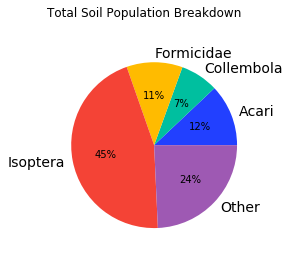

In [27]:
Labels=['Acari','Collembola','Formicidae','Isoptera','Other']

fig, ax = plt.subplots(1, 1,figsize=[4,4])
fig.suptitle('Total Soil Population Breakdown',fontdict={'size':20})

ax.pie(tot_biomass_taxon.median(), colors=col_arr, labels=Labels,autopct='%1.0f%%')
#ax.pie(tot_biomass_taxon.apply(lambda x: np.percentile(x,2.5)), colors=col_arr, labels=Labels,autopct='%1.0f%%')

plt.tight_layout()

if save_bool:
    fig.savefig('results/figs/png/Soil pie.png', dpi=300)
    fig.savefig('results/figs/Soil pie.pdf', dpi=300)
else:
    plt.show()

In [28]:
#calculate data normalized according to area
mg_m2 = (tot_biomass_taxon.median()*1e15) / biome_area1.sum()[1]
mg_ind = soil_ratio_filt_full.loc[:,'Total average (mg/ind)']
num_m2 = mg_m2 / mg_ind

#num_m2.sum()
print('area:' + '{:.2f}'.format(biome_area1.sum()[1]/1e14) + ' x 1e14 m^2')
print('\nBiomass density (mg/m^2) - in soil: (' +  '{:.0f}'.format(mg_m2.sum()) + ' total )')
print(mg_m2)
print('\nPopulation density from biomass density (ind./m^2) - in soil: (' +  '{:.0f}'.format(num_m2.sum()) + ' total )')
print(num_m2)

print('\nTotal population density from 10^19 individuals:' +  '{:.0f}'.format(1e19/biome_area1.sum()[1]))

area:1.32 x 1e14 m^2

Biomass density (mg/m^2) - in soil: (1652 total )
aggregated taxon
Acari         199.048549
Collembola    122.450534
Formicidae    180.181768
Isoptera      749.227758
Other         401.110619
dtype: float64

Population density from biomass density (ind./m^2) - in soil: (61761 total )
aggregated taxon
Acari         38670.892995
Collembola    21562.575345
Formicidae      279.867876
Isoptera       1058.379790
Other           189.099751
dtype: float64

Total population density from 10^19 individuals:76021


In [29]:
print(tot_biomass_taxon.median().Formicidae)
print(tot_biomass_taxon.mean().Formicidae)

23.70165033773298
26.38169962422042


### Calculate the soil biomass under different assumptions (using sub-phyla etc.), without using abundance

In [30]:
#calculate the biomass completely, allowing to change grouping assumptions and data
def calc_boot_full(data,GroupBy,filename='test',N_boot=10000,N_samp=10000,Nbins=500,return_dist=False,
                   is_population=False,save_bool=save_bool,xlabel = 'Dry Biomass [Mt]',ylabel='Probability Density\n[arb. units]',color=Habitat_Color[0]):

    data_site = averaged_sum_site(data,GroupBy)
    Stats, CDF = boot(data_site,GroupBy,N=N_boot)
    tots = dens_2_tot(Stats,area=biome_area1)
    if is_population:
        tots.loc[:,['Total','Total_low','Total_high']]*=1e15
        print('Total Population from Stats (extended range): \n' + prnt_stats_pop(tots))
        samp_dist_tots = cdf_2_tot(CDF,area=biome_area1, N_samps = N_samp)
        samp_dist_tots*=1e15
        Overall_tots = samp_dist_tots.sum(axis=0) *1e-18
        print("Total population from Monte-Carlo: \n"+ prnt_monte_pop(Overall_tots*1e18))
    
    else:
        print('Total biomass from Stats (extended range): \n' + prnt_stats(tots))
        samp_dist_tots = cdf_2_tot(CDF,area=biome_area1, N_samps = N_samp)
        Overall_tots = samp_dist_tots.sum(axis=0)
        print("Total biomass from Monte-Carlo: \n"+ prnt_monte(Overall_tots))
    

    plot_biomass(Overall_tots,color=color, xlabel = xlabel, ylabel=ylabel,
                 save_bool = save_bool , filename=filename,norm_to_1=True, show=False)
    if return_dist:
        return Stats, tots, Overall_tots, samp_dist_tots
    else:
        return Stats, tots, Overall_tots

Total biomass from Stats (extended range): 
Mean: 178 (Range:82-317) Mt
Total biomass from Monte-Carlo: 
Median: 177 (95% CI:148-210) Mt


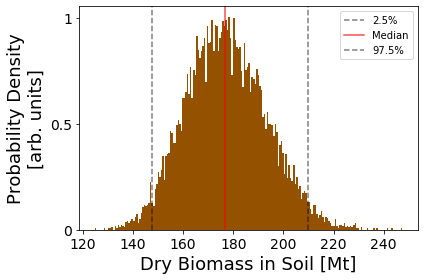

In [31]:
#N_boot=10000
#N_samp=10000
Nbins=200

soil_data_mass = soil_data[soil_data['units type']=='mg'] #Soil data with only direct mass measurements

#aggregating soil data by: sub-phyla, biome
sp1_Stats,sp1_tots, sp1_Overall_tots = calc_boot_full(data=soil_data_mass,GroupBy=['sub-phylum','aggregated biome'],filename='subphyla soil Biomass',
               N_boot=N_boot,N_samp=N_samp,Nbins=Nbins,
               save_bool=save_bool,xlabel = 'Dry Biomass in Soil [Mt]')


Aggregating mass soil data by: taxon, biome
Total biomass from Stats (extended range): 
Mean: 244 (Range:114-443) Mt
Total biomass from Monte-Carlo: 
Median: 243 (95% CI:203-291) Mt

Aggregating soil data by: taxon, sub-phyla, biome
Total biomass from Stats (extended range): 
Mean: 274 (Range:115-517) Mt
Total biomass from Monte-Carlo: 
Median: 273 (95% CI:233-322) Mt


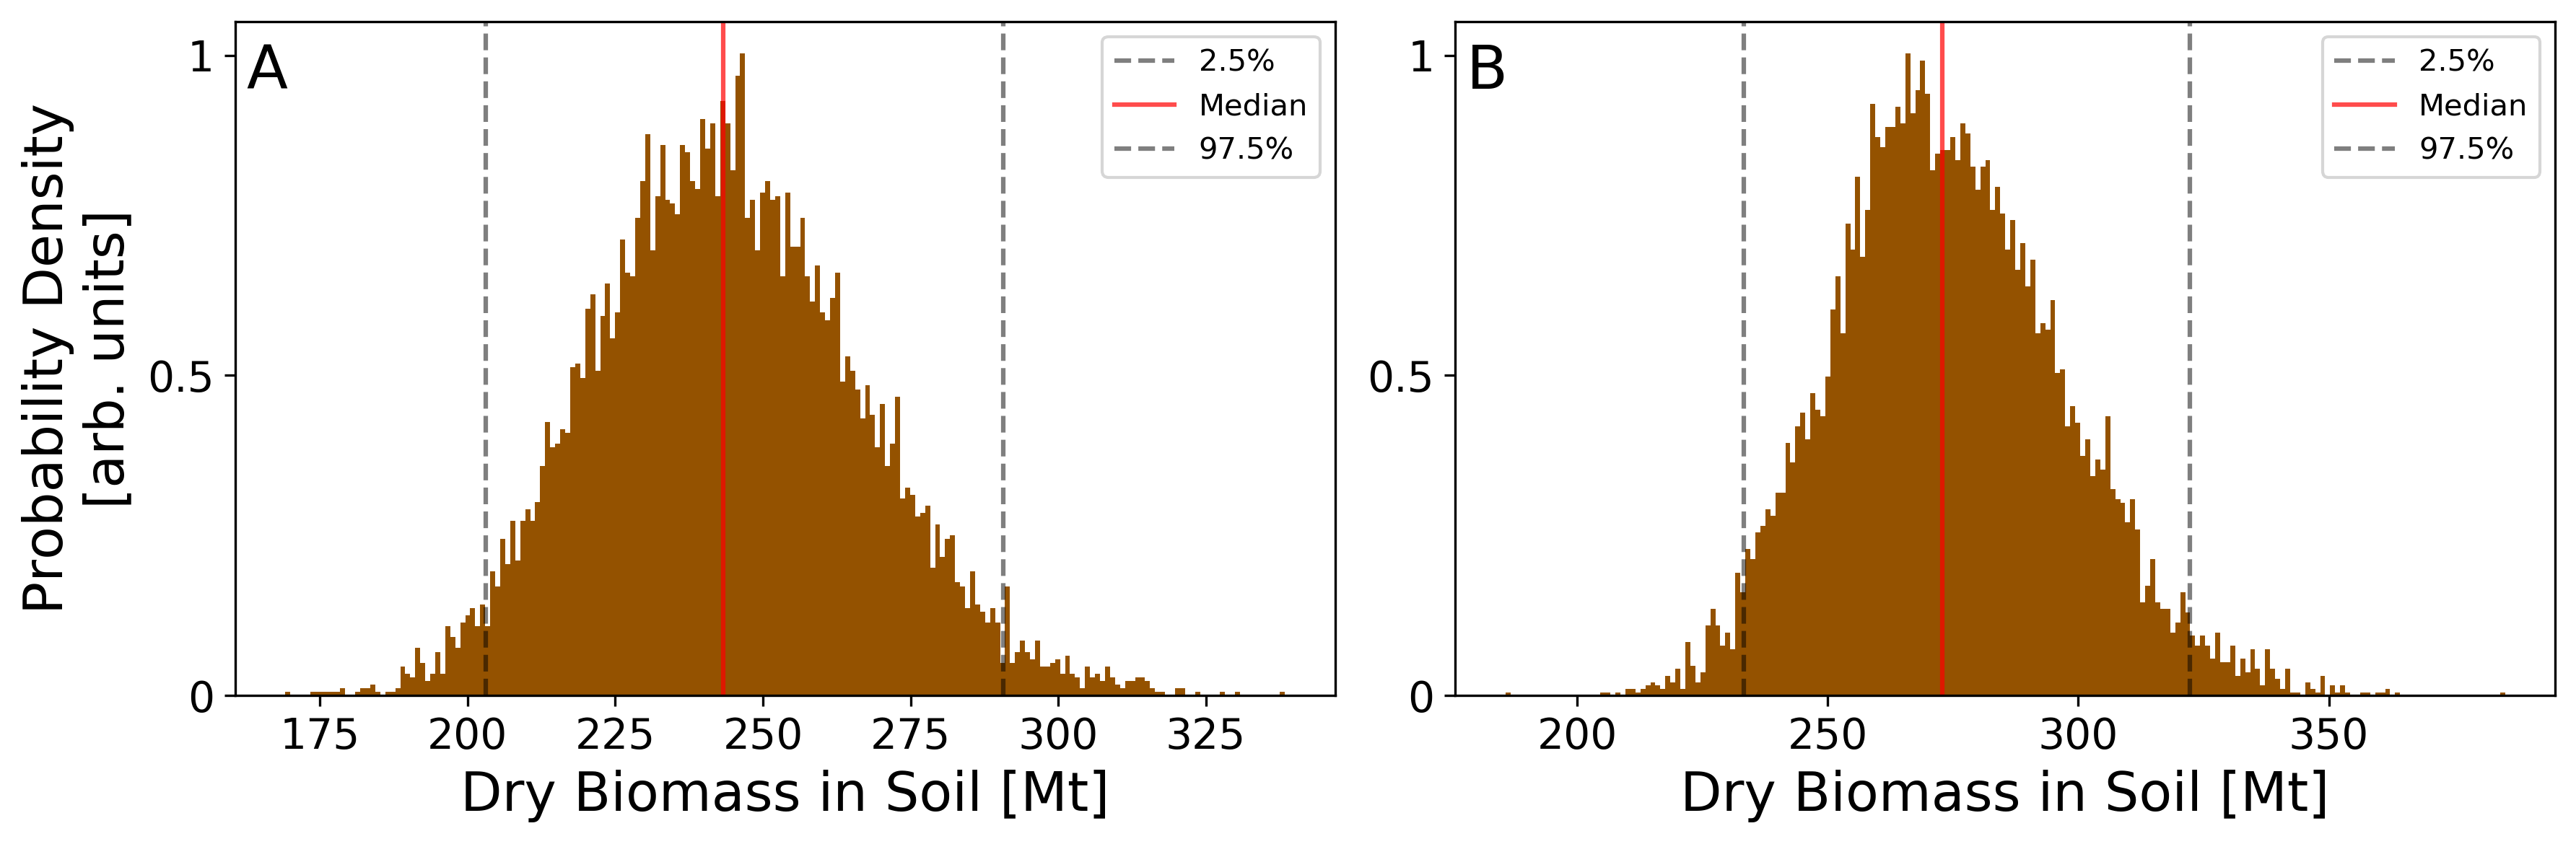

In [32]:
# Sensitivity analysis for soil data: check how using only mass data would change the results    
fig,ax = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax = plt.subplot(1,2,1)

#aggregating mass soil data by: aggregated taxon, aggregated biome
print('Aggregating mass soil data by: taxon, biome')
b_Stats,b_tots, b_Overall_tots = calc_boot_full(data=soil_data_mass,GroupBy=['aggregated taxon','aggregated biome'],filename='mass only soil Biomass',
               N_boot=N_boot,N_samp=N_samp,Nbins=Nbins,
               save_bool=False,xlabel = 'Dry Biomass in Soil [Mt]')

ax.text(0.01,0.9,'A',fontdict={'size':20},transform = ax.transAxes)

ax = plt.subplot(1,2,2)

#aggregating soil data by: aggregated taxon, sub-phyla, aggregated biome
print('\nAggregating soil data by: taxon, sub-phyla, biome')
tx_sp_Stats,tx_sp_tots, tx_sp_Overall_tots = calc_boot_full(data=soil_data_mass,GroupBy=['aggregated taxon','sub-phylum','aggregated biome'],filename='taxa and subphyla soil Biomass',
               N_boot=N_boot,N_samp=N_samp,Nbins=Nbins,
               save_bool=False,xlabel = 'Dry Biomass in Soil [Mt]',ylabel='')

ax.text(0.01,0.9,'B',fontdict={'size':20},transform = ax.transAxes)

plt.tight_layout()
#if save_bool:
#    plt.savefig('results/figs/S8 - Soil_mass_only distributions.pdf',dpi=300)
#    plt.savefig('results/figs/png/S8 - Soil_mass_only distributions.png',dpi=300)

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Total soil biomass from Stats (extended range): 
Mean: 242 (Range:103-451) Mt
Total soil biomass from Monte-Carlo: 
Median: 241 (95% CI:208-283) Mt


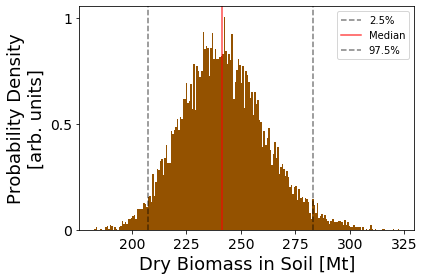

In [33]:
#calculate soil biomass by also dividing according to sub-phyla, including all possible datapoints, using effective mass: DO~~~### 
soil_site_data_mass_all_SP = average_with_eff_mass(soil_data,GroupBy=['units type','aggregated taxon','sub-phylum','aggregated biome']) #data to be used. Contains all soil data, converted into dry biomass
soil_Stats_SP, CDF_SP = boot(soil_site_data_mass_all_SP,GroupBy=['aggregated taxon','sub-phylum','aggregated biome'],N=N_boot)
soil_tots_SP = dens_2_tot(soil_Stats_SP,area=biome_area1)
print('Total soil biomass from Stats (extended range): \n' + prnt_stats(soil_tots_SP))

samp_dist_tots_SP = cdf_2_tot(CDF_SP,area=biome_area1, N_samps = N_samp)
soil_Overall_tots_SP = samp_dist_tots_SP.sum(axis=0)
print("Total soil biomass from Monte-Carlo: \n"+ prnt_monte(soil_Overall_tots_SP))

plot_biomass(soil_Overall_tots_SP,color=Habitat_Color[0], xlabel = 'Dry Biomass in Soil [Mt]', ylabel='Probability Density\n[arb. units]',
             save_bool = save_bool , filename='Soil Biomass sub-phyla (including eff. mass)')

#tot_biomass_taxon_SP = samp_dist_tots_SP.groupby('aggregated taxon').sum().T

In [34]:
unique_sites_per_biome = soil_site_data_mass_all_SP.groupby(['aggregated taxon','aggregated biome'])['site'].nunique().reset_index() #number of unique sites per biome
unique_sites_per_biome_SP = soil_site_data_mass_all_SP.groupby(['aggregated taxon','sub-phylum','aggregated biome'])['site'].nunique().reset_index() #number of unique sites per sub-phylum and biome
unique_sites = unique_sites_per_biome_SP.merge(unique_sites_per_biome,on=['aggregated taxon','aggregated biome'])
unique_sites.loc[:,'correction_term'] = unique_sites.site_x/unique_sites.site_y
unique_sites.drop(['site_x','site_y'],axis=1,inplace=True)
soil_tots_SP_correct = soil_tots_SP.merge(unique_sites,on=['aggregated taxon','sub-phylum','aggregated biome'])
soil_tots_SP_correct.loc[:,'Total_corrected'] = soil_tots_SP_correct.loc[:,'Total']*soil_tots_SP_correct.loc[:,'correction_term']

soil_tots_SP_correct.loc[:,'Total_corrected'] = soil_tots_SP_correct.loc[:,'Total']*soil_tots_SP_correct.loc[:,'correction_term']
SP_tot = soil_tots_SP_correct.groupby('sub-phylum').Total_corrected.sum().drop(['Mixed'])
100*SP_tot/SP_tot.sum()

sub-phylum
Chelicerata    13.858338
Crustacea       1.691451
Hexapoda       76.872083
Myriapoda       7.578128
Name: Total_corrected, dtype: float64

In [35]:
SP_tot.sum()/tot_biomass_taxon.sum(axis=1).median()

1.0044056962106698

## print('Total soil biomass from Stats (extended range): \n' + prnt_stats(soil_tots_SP))

samp_dist_tots_SP = cdf_2_tot(CDF_SP,area=biome_area1, N_samps = N_samp)
soil_Overall_tots_SP = samp_dist_tots_SP.sum(axis=0)
print("Total soil biomass from Monte-Carlo: \n"+ prnt_monte(soil_Overall_tots_SP))

plot_biomass(soil_Overall_tots_SP,color=Habitat_Color[0], xlabel = 'Dry Biomass in Soil [Mt]', ylabel='Probability Density\n[arb. units]',
             save_bool = save_bool , filename='Soil Biomass sub-phyla (including eff. mass)')

#tot_biomass_taxon_SP = samp_dist_tots_SP.groupby('aggregated taxon').sum().T

Total biomass from Stats (extended range): 
Mean: 136 (Range:76-217) Mt
Total biomass from Monte-Carlo: 
Median: 135 (95% CI:109-166) Mt


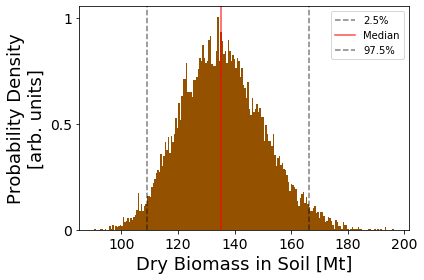

In [36]:
#aggregating soil data by: only biomes
b_Stats,b_tots, b_Overall_tots = calc_boot_full(data=soil_data_mass,GroupBy=['aggregated biome'],filename='biome only soil Biomass',
               N_boot=N_boot,N_samp=N_samp,Nbins=Nbins,
               save_bool=save_bool,xlabel = 'Dry Biomass in Soil [Mt]')

#subphyla_sum = tx_sp_tots.groupby('sub-phylum').Total.apply(np.nansum).drop('Mixed').sort_values(ascending=False)
#del subphyla_sum.index.name
subphyla_sum.plot.pie(colors=['#795548', '#4db6ac','#607d8b','#bdbdbd'],autopct='%1.0f%%')
#plt.pie(subphyla_sum.values,labels=subphyla_sum.index,colors=['#795548', '#4db6ac','#607d8b','#bdbdbd'],autopct='%1.0f%%')
#subphyla_sum


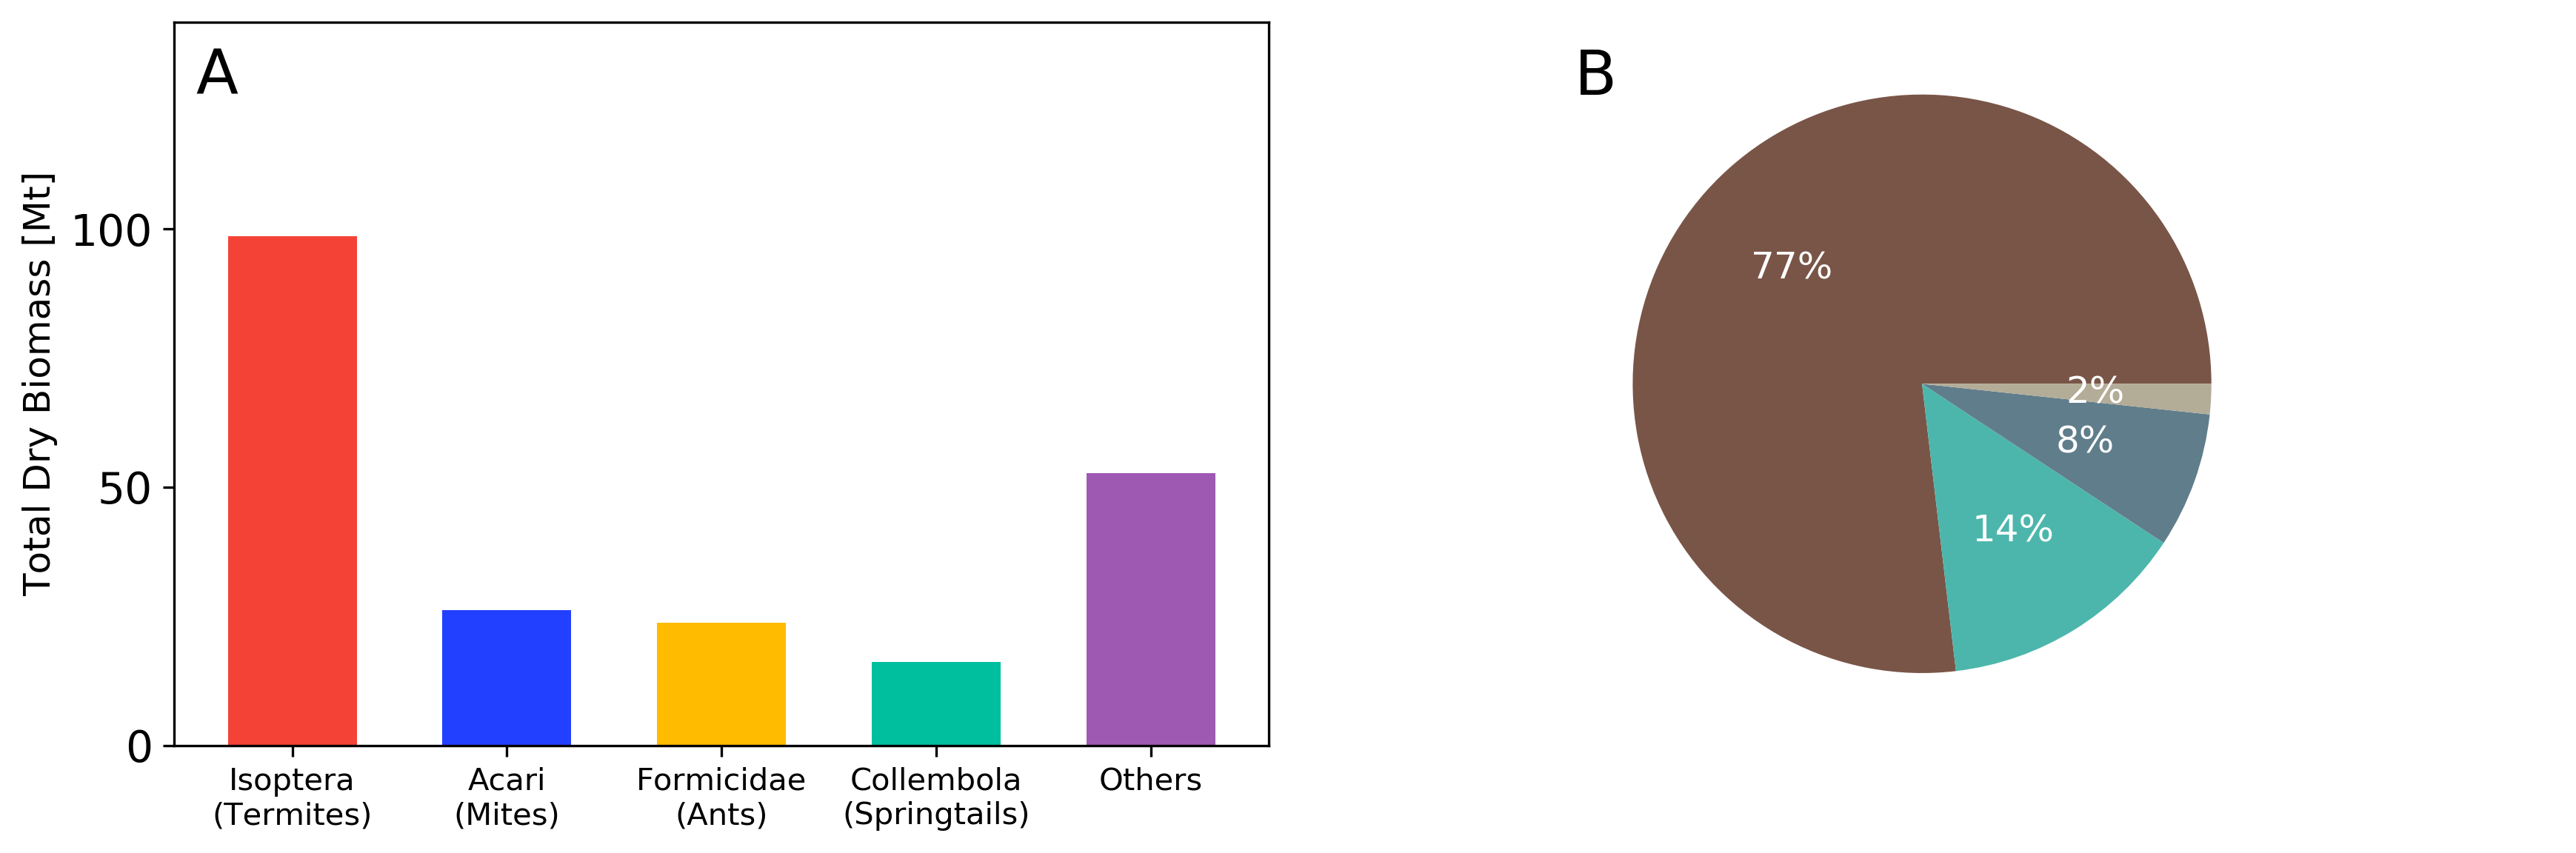

In [37]:
plt.rcParams.update({'font.size': 12}) #increase the font size here
plt.rc('text', usetex=False)

#soil_tots.Total

fig,ax1 = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax1 = plt.subplot(1,2,1)
group_sum = tot_biomass_taxon.median()
group_colors = pd.Series(col_arr,index = group_sum.index)
new_index = ['Isoptera','Acari','Formicidae','Collembola','Other']
group_sum = group_sum.reindex(new_index)
group_colors = group_colors.reindex(new_index)

group_sum.index = ['Isoptera\n(Termites)','Acari\n(Mites)','Formicidae\n(Ants)','Collembola\n(Springtails)','Others']

group_colors.index = group_sum.index
group_sum.plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax1)
ax1.set_ylabel('Total Dry Biomass [Mt]')
plt.xticks(fontsize=10)

ax2 = plt.subplot(1,2,2)
subphyla_sum = SP_tot.sort_values(ascending=False)#~~~#~#~#~tx_sp_tots.groupby('sub-phylum').Total.apply(np.nansum).drop('Mixed').sort_values(ascending=False)
#del subphyla_sum.index.name
subphyla_sum.index.name='' ###
subphyla_sum.name = ''
subphyla_sum.index = '       '+subphyla_sum.index
#subphyla_colors = pd.Series(['#795548', '#4db6ac','#607d8b','#bdbdbd'],index = subphyla_sum.index)
#subphyla_sum.plot.bar(width = 0.5,color=subphyla_colors.loc[subphyla_sum.index],ax=ax2,rot=0)
#plt.pie(subphyla_sum.values,labels=subphyla_sum.index,colors=['#795548', '#4db6ac','#607d8b','#bdbdbd'],autopct='%1.0f%%',ax=ax2)
subphyla_sum.plot.pie(colors=['#795548', '#4db6ac','#607d8b','#B3AC97'],autopct='%1.0f%%',textprops={'color':"w"},ax=ax2)#colors=['#795548', '#4db6ac','#607d8b','#bdbdbd']['#97887E', '#F1E3D2','#D9E0E5','#939BB2']['#985A0D', '#F1B97D','#79BCE5','#687CB2']
#plt.xticks(fontsize=10)

ax1.set_ylim([0,140])
#ax2.set_ylim([0,260])
ax1.set(yticks=np.arange(0,140,50))
#ax2.set(yticks=np.arange(0,251,50))

ax1.text(0.02,0.9,'A',fontdict={'size':20},transform = ax1.transAxes)
ax2.text(0.02,0.9,'B',fontdict={'size':20},transform = ax2.transAxes)
plt.tight_layout()

if False:
    plt.savefig('results/figs/fig6-total_biomass_per_taxon1.pdf', dpi=300)##
else:
    plt.show()

plt.rcParams.update({'font.size': 10}) #decrease back the font size here

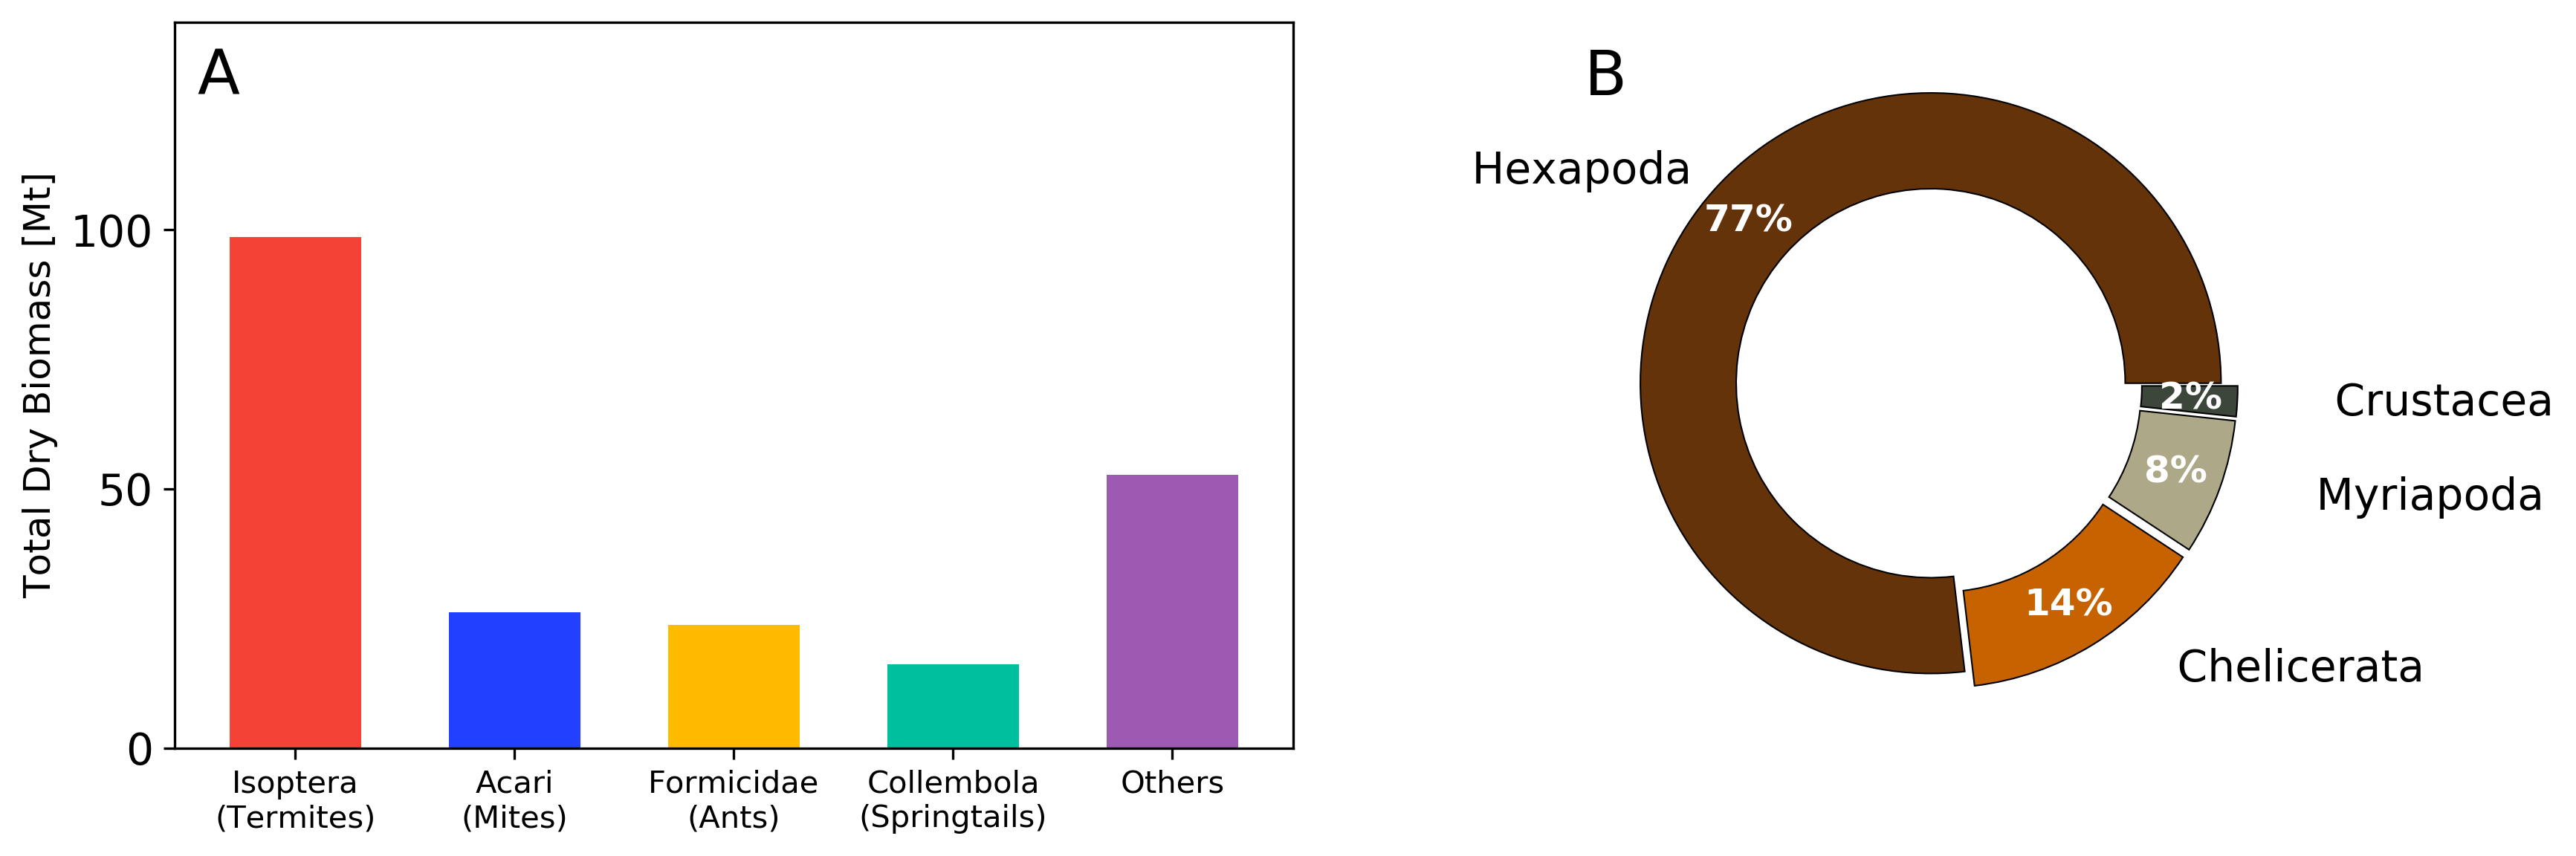

In [38]:
plt.rcParams.update({'font.size': 12}) #increase the font size here
plt.rc('text', usetex=False)

#soil_tots.Total

fig,ax1 = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax1 = plt.subplot(1,2,1)
group_sum = tot_biomass_taxon.median()
group_colors = pd.Series(col_arr,index = group_sum.index)
new_index = ['Isoptera','Acari','Formicidae','Collembola','Other']
group_sum = group_sum.reindex(new_index)
group_colors = group_colors.reindex(new_index)

group_sum.index = ['Isoptera\n(Termites)','Acari\n(Mites)','Formicidae\n(Ants)','Collembola\n(Springtails)','Others']

group_colors.index = group_sum.index
group_sum.plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax1)
ax1.set_ylabel('Total Dry Biomass [Mt]',fontdict={'size':18})
plt.xticks(fontsize=10)

ax2 = plt.subplot(1,2,2)
subphyla_sum = SP_tot.sort_values(ascending=False)
labels = '     '+subphyla_sum.index


patches, texts, pcts = ax2.pie(
    subphyla_sum, labels=labels, 
#    colors=['#795548', '#4db6ac','#607d8b','#B3AC97'],['#4E2301', '#B19A7D','#EFCF81','#ECEDD6']
    colors=['#65330A', '#C66300','#ADA887','#3C463B'],
    autopct='%1.0f%%',pctdistance=0.84,textprops={'color':"k"},
    wedgeprops={'width':0.33,'edgecolor':'black', 'linewidth':0.5},
    startangle=0,explode = (0.01, 0.05, 0.05, 0.05))

# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold')


ax1.set_ylim([0,140])
ax1.set(yticks=np.arange(0,140,50))

ax1.text(0.02,0.9,'A',fontdict={'size':20},transform = ax1.transAxes)
ax2.text(0.02,0.9,'B',fontdict={'size':20},transform = ax2.transAxes)
plt.tight_layout()

if save_bool:
    plt.savefig('results/figs/total_biomass_per_taxon (fig6).pdf', dpi=300)##
else:
    plt.show()

plt.rcParams.update({'font.size': 10}) #decrease back the font size here

[None, None, None, None, None, None, None, None]

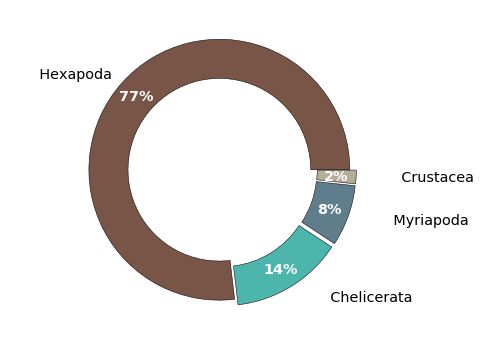

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))

subphyla_sum = SP_tot.sort_values(ascending=False)
labels = '       '+subphyla_sum.index

patches, texts, pcts = ax.pie(
    subphyla_sum, labels=labels, 
    colors=['#795548', '#4db6ac','#607d8b','#B3AC97'],
    autopct='%1.0f%%',pctdistance=0.85,textprops={'color':"k",'size': 'x-large'},
    wedgeprops={'width':0.3,'edgecolor':'black', 'linewidth':0.5},
    startangle=0,explode = (0.0, 0.05, 0.05, 0.05))

# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold')

#subphyla_sum.index.name='' ###
#subphyla_sum.name = ''
##subphyla_sum.index = '       '+subphyla_sum.index
##patches, texts, pcts = subphyla_sum.plot.pie(colors=['#795548', '#4db6ac','#607d8b','#B3AC97']
##                      ,autopct='%1.0f%%',pctdistance=0.85,textprops={'color':"k"}
##                      ,startangle=0,explode = (0.0, 0.05, 0.05, 0.05)
##                      ,wedgeprops={'width':0.3,'edgecolor':'black', 'linewidth':0.5})




12. Calculate the overall total population, assuming places with no data has no individuals

Total Population from Stats (extended range): 
Mean: 1.0e+19 (Range:4.8e+18-1.8e+19) individuals
Total population from Monte-Carlo: 
Median: 1.0e+19 (95% CI:8.2e+18-1.3e+19) individuals


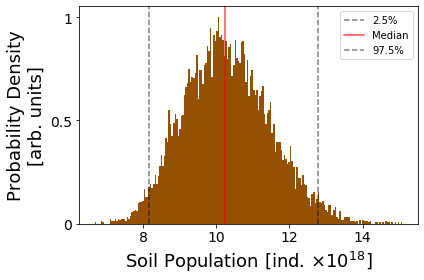

In [40]:
#N_boot=10000
#N_samp=10000###~~~
#Nbins=200

#aggregating population in soil data by: taxon, biome 
soil_data_pop = soil_data[soil_data['units type']=='individuals']

soil_pop_Stats,soil_pop_tots, soil_pop_Overall_tots, soil_pop_dist = calc_boot_full(data=soil_data_pop,GroupBy=['aggregated taxon','aggregated biome'],filename='pop in soil',
               N_boot=N_boot,N_samp=N_samp,Nbins=Nbins,return_dist=True,
               is_population=True, save_bool=save_bool,xlabel = r'Soil Population [ind. $\times 10^{18}$]')

#tot_pop_taxon = soil_pop_dist.groupby('aggregated taxon').sum().T

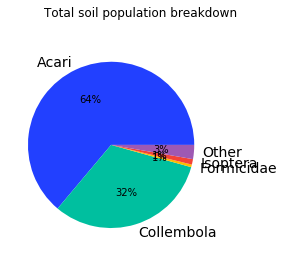

In [41]:
#~!~ Change presentation if want to use

tot_taxon_pop = soil_pop_dist.groupby('aggregated taxon').sum().T

#col_arr = ['#4285F4','#00A88C','#FFBB00','#f44336','#9e59b3']#~~~
Labels=['Acari','Collembola','Formicidae','Isoptera','Other']

fig, ax = plt.subplots(1, 1,figsize=[4,4])
fig.suptitle('Total soil population breakdown',fontdict={'size':20})

ax.pie(tot_taxon_pop.median(), colors=col_arr, labels=Labels,autopct='%1.0f%%')
#ax.pie(tot_biomass_taxon.apply(lambda x: np.percentile(x,2.5)), colors=col_arr, labels=Labels,autopct='%1.0f%%')

plt.tight_layout()

if save_bool:
    fig.savefig('results/figs/png/Soil pie population.png', dpi=300)
    fig.savefig('results/figs/Soil pie population.pdf', dpi=300)
else:
    plt.show()

Total Population from Stats (extended range): 
Mean: 1.3e+17 (Range:5.3e+16-2.2e+17) individuals
Total population from Monte-Carlo: 
Median: 1.3e+17 (95% CI:9.0e+16-1.8e+17) individuals


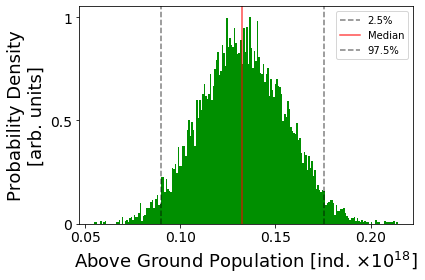

In [42]:
above_ground_data_pop = above_ground_data[above_ground_data['units type']=='individuals']

above_ground_pop_Stats,above_ground_pop_tots, above_ground_pop_Overall_tots = calc_boot_full(data=above_ground_data_pop,GroupBy=['aggregated biome'],filename='pop above ground',
               N_boot=N_boot,N_samp=N_samp,Nbins=Nbins,color=Habitat_Color[2],
               is_population=True, save_bool=save_bool,xlabel = r'Above Ground Population [ind. $\times 10^{18}$]')

Overall_population
Median: 1.0e+01 (95% CI:8.3e+00-1.3e+01) individuals
Range: 4.9e+18 - 1.8e+19 individuals


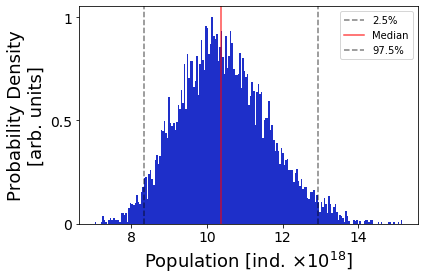

In [43]:
#Total population:
Overall_pop = comb_tots(soil_pop_Overall_tots,above_ground_pop_Overall_tots,N_samps=N_samp,Nbins=Nbins)
print('Overall_population\n'+ prnt_monte_pop(Overall_pop))

Overall_low = soil_pop_tots.Total_low.sum()+above_ground_pop_tots.Total_low.sum()
Overall_high = soil_pop_tots.Total_high.sum()+above_ground_pop_tots.Total_high.sum()
print('Range: ' + prtF_pop(Overall_low) + ' - ' + prtF_pop(Overall_high) + ' individuals')

plot_biomass(Overall_pop,color='#1e2fc9', xlabel = r'Population [ind. $\times 10^{18}$]', ylabel='Probability Density\n[arb. units]',
             save_bool = save_bool , filename='All Population')

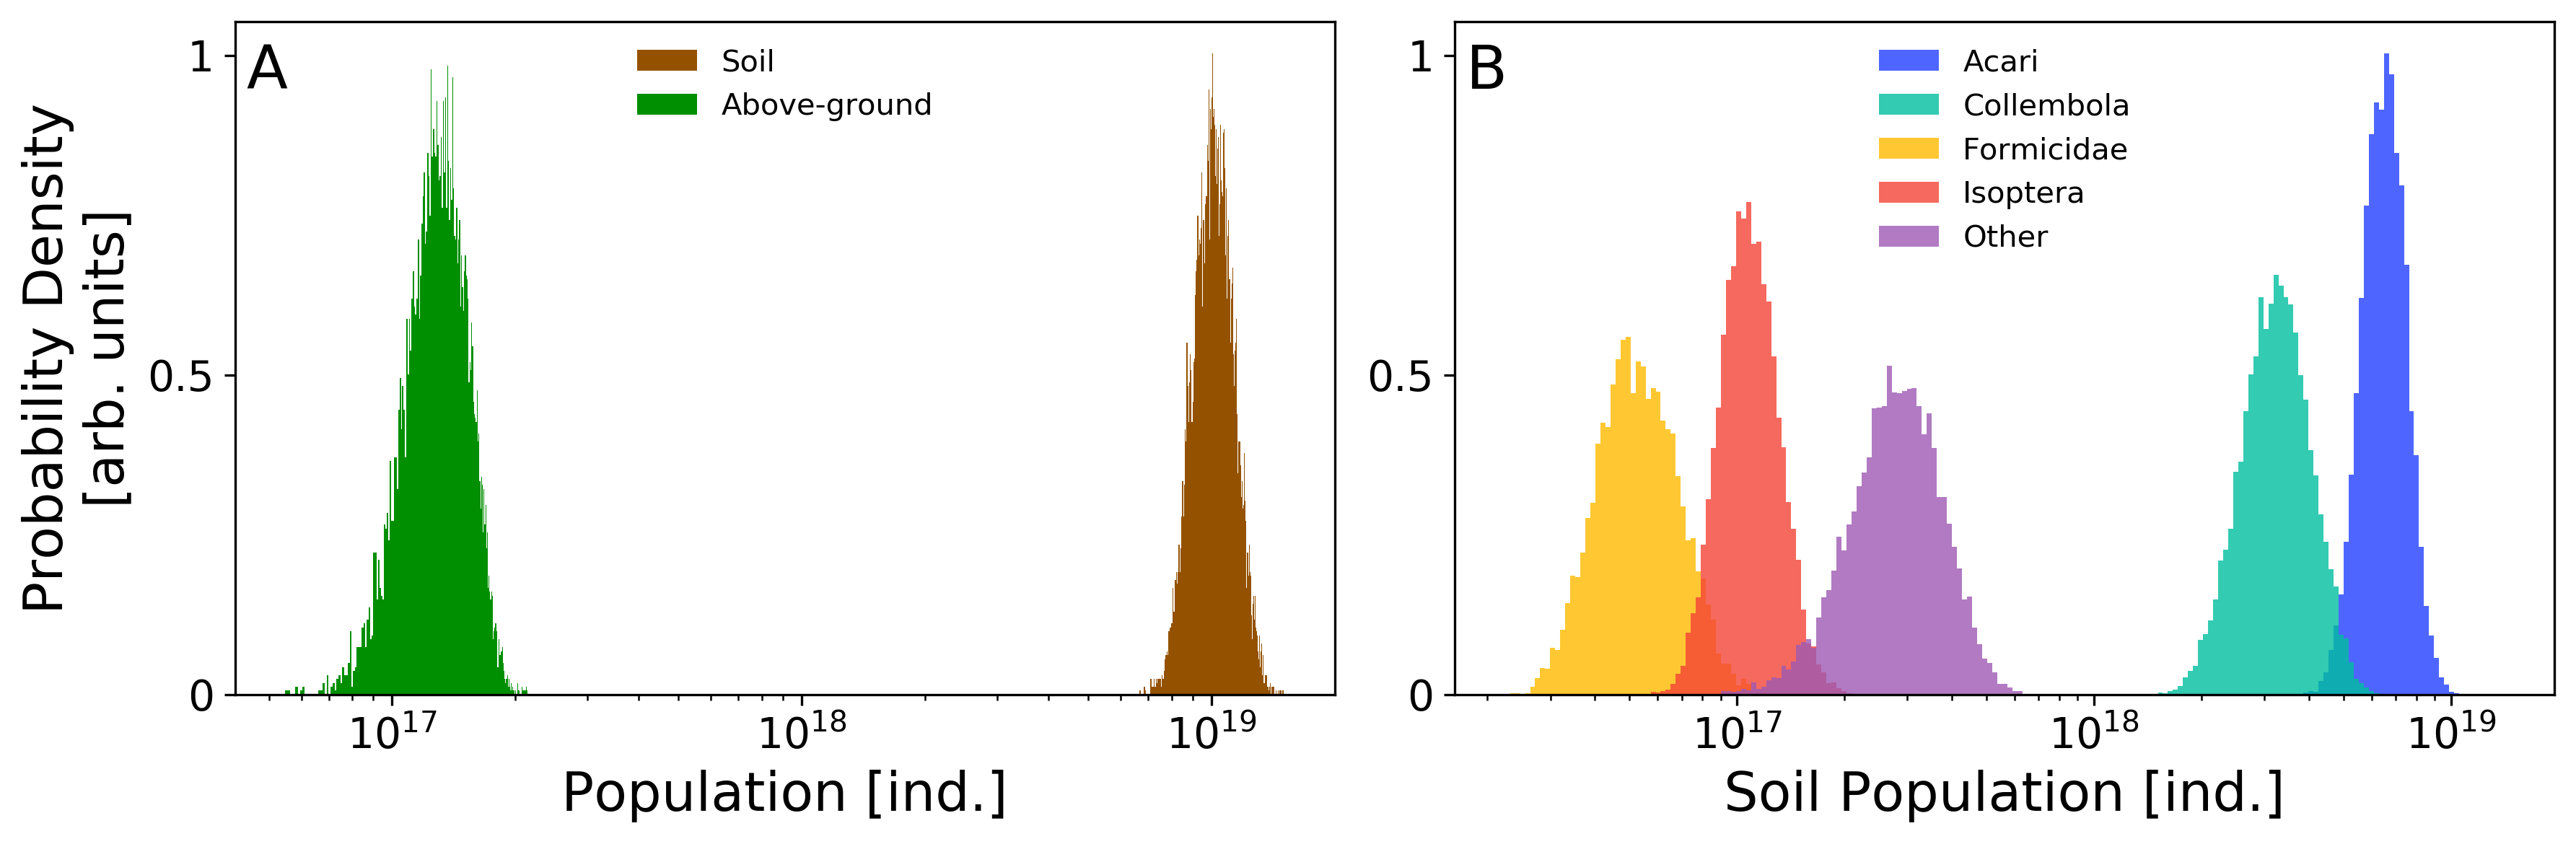

In [44]:
#Save plots population.

fig,ax = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax = plt.subplot(1,2,1)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

Habitat_Color=['#945200','#FFD479','#008F00']     
plot_biomass_comb(soil_pop_Overall_tots*1e18,xlabel = 'Population [ind]', color=Habitat_Color[0],log=True,alpha=1)
plot_biomass_comb(above_ground_pop_Overall_tots*1e18,xlabel = 'Population [ind.]',color=Habitat_Color[2],log=True,alpha=1)

mx=ax.get_ylim()[1]*0.95#np.max(np.histogram(above_ground_pop_Overall_tots,bins=200)[0])
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'A',fontdict={'size':20},transform = ax.transAxes)

plt.legend(['Soil','Above-ground'],frameon=False,loc='upper center')#loc=[0.08,0.84])


ax = plt.subplot(1,2,2)

tot_taxon_pop.plot.hist(bins=np.logspace(16.35,19.15, 200),ax=ax, alpha=0.8,color=col_arr)
plt.gca().set_xscale("log")

plt.xlabel('Soil Population [ind.]',size = 18)
plt.ylabel('',size = 18)

ax.legend(title='',frameon=False,loc='upper center')

mx=ax.get_ylim()[1]*0.95#np.max(np.histogram(tot_taxon_pop,bins=np.logspace(16.35,19.15, 200))[0])#*0.61
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'B',fontdict={'size':20},transform = ax.transAxes)

plt.tight_layout()

if save_bool:
    plt.savefig('results/figs/Habitats_population.pdf',dpi=300)
else:
    plt.show()



biome_totals_pop = pd.read_csv('results/tables/table_biome_totals_pop.csv')
biome_totals_pop

In [45]:
#Combine biome totals for plotting
Soil_mass = soil_tots.groupby('aggregated biome').sum().loc[:,['Total','Total_low','Total_high']].reset_index()
Soil_mass.insert(0, 'env', 'soil',True)

above_ground_mass = above_ground_tots.groupby('aggregated biome').sum().loc[:,['Total','Total_low','Total_high']].reset_index()
above_ground_mass.insert(0, 'env', 'above_ground',True)

biome_totals_mass = pd.concat([Soil_mass, above_ground_mass])

#population:
Soil_pop = soil_pop_tots.groupby('aggregated biome').sum().loc[:,['Total','Total_low','Total_high']].reset_index()
Soil_pop.insert(0, 'env', 'soil',True)

above_ground_pop = above_ground_pop_tots.groupby('aggregated biome').sum().loc[:,['Total','Total_low','Total_high']].reset_index()
above_ground_pop.insert(0, 'env', 'above_ground',True)

biome_totals_pop = pd.concat([Soil_pop, above_ground_pop])

biome_totals_pop.head()

,env,aggregated biome,Total,Total_low,Total_high
0,soil,Boreal Forests/Taiga,3.447186e+18,1.592931e+18,6.019428e+18
1,soil,Crops,3.968017e+17,1.755935e+17,7.276333e+17
2,soil,Deserts and Xeric Shrublands,1.835852e+16,5.647062e+15,3.444614e+16
3,soil,"Mediterranean Forests, Woodlands and Scrub",4.922754e+16,1.273458e+16,1.098622e+17
4,soil,Pasture,4.594295e+17,9.146147e+16,9.300107e+17


In [46]:
#Export to tables

def print_export_tot(mean,low,high,N=2,is_pop=False): #print the mean and range (low-high) rounded to N significant digits, for exporting data tables
    if is_pop:
        mean = round_significant_N(mean/1e15,N)
        low = round_significant_N(low/1e15,N)
        high = round_significant_N(high/1e15,N)
    else:
        mean = round_significant_N(mean,N)
        low = round_significant_N(low,N)
        high = round_significant_N(high,N)
    
    txt='{MEAN} ({LOW}-{HIGH})'
    return txt.format(MEAN=mean, LOW=low, HIGH=high)

def export_tot_table(biome_totals,is_pop,N): #convert the biomas totals DF to a pivotted table to be exported. is_pop=is the data a population data. N=number of significant digits
    biome_totals_exp = biome_totals.groupby(['env','aggregated biome']).mean() #groupby environment and biomes. The mean doesnt really do anything
    Habitat_totals_sums = biome_totals.groupby(['env']).sum()
    
    biome_totals_exp = biome_totals_exp.apply(lambda x : print_export_tot(x.Total, x.Total_low,x.Total_high,N=N,is_pop=is_pop),axis=1).reset_index()
    Habitat_totals_sums = Habitat_totals_sums.apply(lambda x : print_export_tot(x.Total, x.Total_low,x.Total_high,N=N,is_pop=is_pop),axis=1).reset_index()
    biome_totals_exp = pd.concat([biome_totals_exp,Habitat_totals_sums])
    biome_totals_exp.iloc[-len(Habitat_totals_sums):,1]='World Total' #rename the sum of all biomes (Habitat_totals_sums) to "World Total"

    biome_totals_table = pd.pivot(biome_totals_exp,index='aggregated biome', columns='env')
    return biome_totals_table
 
biome_totals_mass_table = export_tot_table(biome_totals_mass,is_pop=False,N=1)
biome_totals_pop_table = export_tot_table(biome_totals_pop,is_pop=True,N=1)

if save_bool:
    biome_totals_mass_table.to_csv('results/tables/table_biome_totals_mass.csv')
    biome_totals_pop_table.to_csv('results/tables/table_biome_totals_pop.csv')

13. Calculate and plot the total population per aggregated biome 

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  app.launch_new_instance()


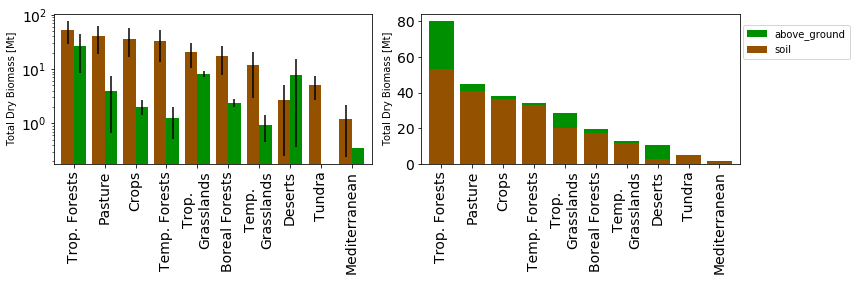

In [47]:
##The total soil biomass calculated here (Gt), using both population and biomass data
#Soil_mass = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].groupby('aggregated biome').sum()/1e15
#Soil_mass=Soil_mass.reset_index()
#Soil_mass.insert(0, 'env', 'soil',True)

##Read the total biomass of above ground and replace the soil biomass to the current estimation 
#biome_totals_mass = pd.read_csv('results/tables/table_biome_totals_mass.csv')
#biome_totals_mass.loc[biome_totals_mass['env']=='soil'] = Soil_mass

#biome_totals_pop = pd.read_csv('results/tables/table_biome_totals_pop.csv')

def sort_by_index(x,sorted_indx):
    sorterIndex = dict(zip(sorted_indx, range(len(sorted_indx))))
    x['sorting_biomes'] = x.index.map(sorterIndex)
    x.sort_values(['sorting_biomes'],ascending = True, inplace = True)
    x.drop('sorting_biomes', 1, inplace = True)
    return x

def data4tot_plot(x):
    #rename labels for plot
    original_biomes = x['aggregated biome']
    transdict = {'Boreal Forests/Taiga': 'Boreal Forests',
             'Crops':'Crops',
             'Deserts and Xeric Shrublands':'Deserts',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean',
             'Pasture':'Pasture',
           'Temperate Forests':'Temp. Forests',
           'Temperate Grasslands, Savannas and Shrublands':'Temp.\nGrasslands',
           'Tropical and Subtropical Forests':'Trop. Forests',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Trop.\nGrasslands',
           'Tundra':'Tundra'
            }
    print_biomes = [transdict[biome] for biome in original_biomes]    
    x['aggregated biome'] = print_biomes
    
#    #sort the environment (habitat tyoe) such that the soil will be plotted at the bottom of the bars (be first)
#    x.columns = pd.CategoricalIndex(x.columns.values, 
#                                 ordered=True, 
#                                 categories=['soil','above_ground'])
#    x = x.sort_index(axis=1)
    
    #extract the total values
    x_tot = x.reset_index().pivot(index = 'aggregated biome' , columns = 'env', values='Total')    
    
    #sort by descending values
    sorter = x_tot.sum(axis=1).sort_values(ascending=False).index
    x_tot = sort_by_index(x_tot ,sorter )
    x_tot = x_tot.sort_index(axis=1,ascending=False) #make sure the soil column is first
    
    #add error bars
    x['err_low'] = (x.loc[:,'Total']-x.loc[:,'Total_low'])
    x['err_high'] = (x.loc[:,'Total_high']-x.loc[:,'Total'])
    
    err_l = x.pivot(index = 'aggregated biome' , columns = 'env', values='err_low' ) 
    err_l = sort_by_index(err_l,x_tot.index)
    err_l = err_l.sort_index(axis=1,ascending=False)
    err_h = x.pivot(index = 'aggregated biome' , columns = 'env', values= 'err_high')
    err_h = sort_by_index(err_l,x_tot.index)
    err_h = err_h.sort_index(axis=1,ascending=False)
    
    #Combine the low and high errors
    err = []
    for col in err_l:  # Iterate over bar groups (represented as columns)
        err.append([err_l[col].values, err_h[col].values])    
        
    return x_tot , err


mass_tots, err_m = data4tot_plot(biome_totals_mass)
pop_tots, err_p= data4tot_plot(biome_totals_pop)


fig = plt.subplots(figsize=[12,4])
ax = plt.subplot(1,2,1)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=['#945200','#008F00'],ax=ax,logy=True,stacked=False,rot=90,legend=False)
ax.set_ylabel('Total Dry Biomass [Mt]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
#ax.legend(loc = [1.01,0.7])
#ax.ticks

ax = plt.subplot(1,2,2)
mass_tots.plot.bar(width = 0.8, color=['#945200','#008F00'],ax=ax,logy=False,stacked=True)
ax.set_ylabel('Total Dry Biomass [Mt]')
#ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[1],handles[0]],[labels[1],labels[0]],loc = [1.01,0.7])

plt.tight_layout()

#plt.savefig('results/fig_pop_biome_totsig_.svg', dpi=300)
#plt.savefig('results/fig_pop_biome_tots.pdf', dpi=300)##

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


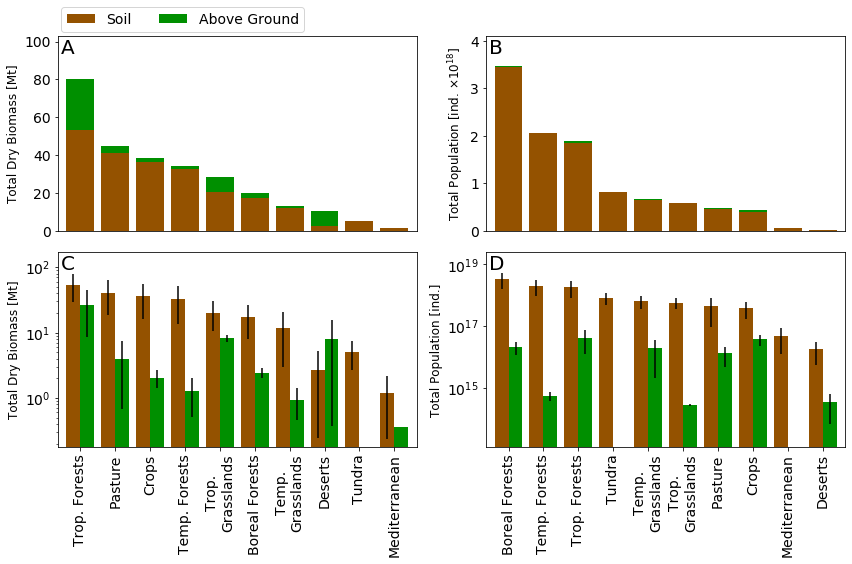

In [48]:
#Plot biomass and population data per biomeand habitat type (environment)
col_env = ['#945200','#008F00']#colors of the environments
plt.rcParams.update({'font.size': 12}) #increase the font size here

fig = plt.subplots(figsize=[12,8])


ax1 = plt.subplot(2,2,1)
mass_tots.plot.bar(width = 0.8, color=col_env,ax=ax1,logy=False,stacked=True)
ax1.set_ylabel('Total Dry Biomass [Mt]')
#ax.xaxis.set_ticklabels(ticklabels)
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
ax1.set_ylim([0,103])
handles, labels = ax1.get_legend_handles_labels()

transdict = {'above_ground': 'Above Ground',
             'soil': 'Soil',
            }
Labels = [transdict[env] for env in labels]

ax1.legend([handles[0],handles[1]],[Labels[0],Labels[1]],loc = [0.01,1.02],ncol=2,fontsize=14)
ax1.text(0.01,0.91,'A',fontdict={'size':20},transform = ax1.transAxes)

ax2 = plt.subplot(2,2,2)
(pop_tots/1e18).plot.bar(width = 0.8, color=col_env,ax=ax2,logy=False,stacked=True)
ax2.set_ylabel(r'Total Population [ind. $\times 10^{18}$]')
#ax.xaxis.set_ticklabels(ticklabels)
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)
ax2.set_ylim([0,4.1])
ax2.get_legend().remove()
ax2.text(0.01,0.91,'B',fontdict={'size':20},transform = ax2.transAxes)


ax3 = plt.subplot(2,2,3)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=col_env,ax=ax3,logy=True,stacked=False,rot=90,legend=False)
ax3.set_ylabel('Total Dry Biomass [Mt]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax3.xaxis.label.set_visible(False)
ax3.set_ylim([0,170])
#ax.legend(loc = [1.01,0.7])
#ax.ticks
ax3.text(0.01,0.91,'C',fontdict={'size':20},transform = ax3.transAxes)

ax4 = plt.subplot(2,2,4)
pop_tots.plot.bar(yerr=err_p ,width = 0.8, color=col_env,ax=ax4,logy=True,stacked=False,rot=90,legend=False)
ax4.set_ylabel('Total Population [ind.]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax4.xaxis.label.set_visible(False)
ax4.set_ylim([1.2e13,2.5e19])
#ax.legend(loc = [1.01,0.7])
#ax.ticks
ax4.text(0.01,0.91,'D',fontdict={'size':20},transform = ax4.transAxes)

plt.tight_layout()

plt.rcParams.update({'font.size': 10}) #increase the font size here

if save_bool:
    plt.savefig('results/figs/fig5-biome tots.pdf', dpi=300)##
    plt.savefig('results/figs/png/fig5-biome tots.png', dpi=300)##
else:
    plt.show()
        

In [49]:
mass_tots.head()

env,soil,above_ground
aggregated biome,,
Trop. Forests,53.231808,26.763683
Pasture,41.006502,3.992996
Crops,36.225559,2.034484
Temp. Forests,32.831840,1.271120
Trop.\nGrasslands,20.235966,8.177023


## plot population density in soil

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


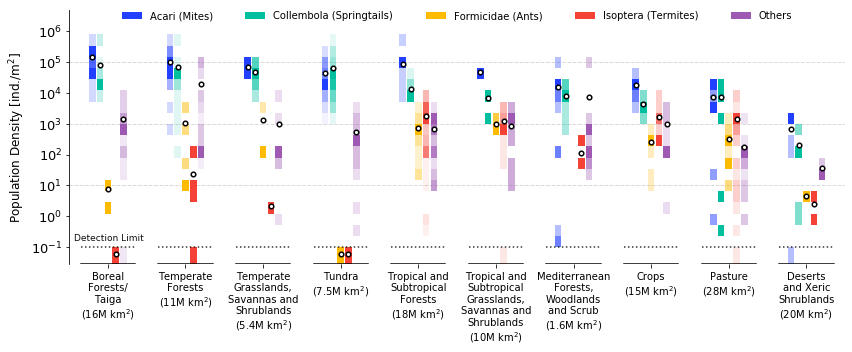

In [101]:
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=False)

#r_pop is the data to be plotted
r_pop = soil_site_data_pop.reset_index() #'population density' is the column being used later

#Sort according to biomes total mean biomass, in a descending order
sorter = soil_pop_Stats.reset_index().groupby('aggregated biome').sum().sort_values(by='mean',ascending=False).index
sorterIndex = dict(zip(sorter, range(len(sorter))))
r_pop['sorting_biomes'] = r_pop['aggregated biome'].map(sorterIndex)
r_pop.sort_values(['sorting_biomes'],ascending = True, inplace = True)
r_pop.drop('sorting_biomes', 1, inplace = True)

original_biomes = r_pop['aggregated biome'].unique()
transdict = {'Boreal Forests/Taiga': 'Boreal\nForests/\nTaiga\n(16M km$^2$)',
             'Crops':'Crops\n(15M km$^2$)',
             'Deserts and Xeric Shrublands':'Deserts\nand Xeric\nShrublands\n(20M km$^2$)',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean\nForests,\nWoodlands\nand Scrub\n(1.6M km$^2$)',
             'Pasture':'Pasture\n(28M km$^2$)',
           'Temperate Forests':'Temperate\nForests\n(11M km$^2$)',
           'Temperate Grasslands, Savannas and Shrublands':'Temperate\nGrasslands,\nSavannas and\nShrublands\n(5.4M km$^2$)',
           'Tropical and Subtropical Forests':'Tropical and\nSubtropical\nForests\n(18M km$^2$)',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands\n(10M km$^2$)',
           'Tundra':'Tundra\n(7.5M km$^2$)'
            }

print_biomes = [transdict[biome] for biome in original_biomes]
r_pop.replace(to_replace=original_biomes,value=print_biomes,inplace=True)

bins = np.logspace(-1,np.log10(r_pop['population density'].max()),20)
bins = np.insert(bins,0,-0.1) #add the point -0.1 to the beginning of the bins array
  
t = r_pop.groupby(['aggregated biome','aggregated taxon'])['population density'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index() #how many in each bin
t_max = t.groupby(['aggregated biome','aggregated taxon'])['population density'].apply(np.max).reset_index() 
t_norm_pop = t.merge(t_max,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon']) #normalize to the maximal bin value
t_norm_pop['val'] = t_norm_pop['population density_x']/t_norm_pop['population density_y']


#Isoptra = Isoptera_data.replace(to_replace=original_biomes,value=print_biomes)


fig,ax=plt.subplots(figsize=[12,5]) #[11,4])

fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
#col_arr = ['#4285F4','#00A88C','#FFBB00','#f44336','#9e59b3']#~~~

def print_data(x):
    col_map = pd.Series(col_arr,index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r_pop['aggregated biome'].unique()),2),index=r_pop['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
    ax.set_yscale('symlog',linthreshy=0.1)
        
#Print fine average of Isoptera
def print_mean_Isoptera(x):
    fine_loc_Iso = 0.2;
    locs = pd.Series(range(0,2*len(r_pop['aggregated biome'].unique()),2),index=r_pop['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc_Iso
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='#EBEBEB', alpha=1,s=15,zorder=4)
    plt.scatter(x=xloc,y=x['Low estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['High estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)


def print_bootstrap(x):
    locs = pd.Series(range(0,2*len(r_pop['aggregated biome'].unique()),2),index=r_pop['aggregated biome'].unique())
    x = x.replace(to_replace=original_biomes,value=print_biomes)
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = x['mean']+0.08
    L = x['2.5%']
    U = x['97.5%']
    plt.scatter(x=xloc,y= Y,marker='o' ,facecolors='w',edgecolors='k', alpha=1,s=21,linewidths=1.5,zorder=3)  #~~~###~~~Change etc. 
#    plt.scatter(x=xloc,y= L,marker='_' ,c='k', alpha=1,s=15,zorder=3)  
#    plt.scatter(x=xloc,y= U,marker='_' ,c='k', alpha=1,s=15,zorder=3) 
   

for i in range(0,2*len(r_pop['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)    #plot dotted lines for breaking points "detection limit"

#Plot data
ax = t_norm_pop.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.plot([-1,19],[1e1,1e1],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax.plot([-1,19],[1e3,1e3],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax.plot([-1,19],[1e5,1e5],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax.set_xticks(range(0,2*len(r_pop['aggregated biome'].unique()),2))
ax.set_xticklabels(r_pop['aggregated biome'].unique(),fontdict={'size':10})
ax.get_label()
ax.set_ylabel('Population Density [ind./m$^2$]',fontdict={'size':12})
#plt.legend()
ax.set_ylim([0.05,5e6])
ax.set_xlim([-1,19])
legend_without_duplicate_labels(ax,(0.5,1.03)) #lower left 0.007 (0.01,0.9)
sb.despine(top=True, bottom=True, right=True)
#Isoptra.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_Isoptera)##
soil_pop_Stats.reset_index().groupby(['aggregated biome','aggregated taxon']).apply(print_bootstrap)###

ax.text(0.007, 0.12, 'Detection Limit', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)

plt.tight_layout()


#Save:
if save_bool:
    plt.savefig('results/fig_pop_dens.pdf',dpi=300) ##
else:
    plt.show()
        


In [51]:
def print_export_pop(mean,low,high,N_sites,N=2): #print the mean and range (low-high) rounded to N significant digits, for exporting data tables
    mean = round_significant_N(mean,N)
    low = round_significant_N(low,N)
    high = round_significant_N(high,N)
    
    if N_sites>1:
        txt='{MEAN}\n({LOW}-{HIGH})\nN = {N_SITES}'
    else: 
        txt='{MEAN}\n\nN = {N_SITES}'
    return txt.format(MEAN=mean, LOW=low, HIGH=high, N_SITES=int(N_sites))

soil_export_pop = soil_pop_Stats.reset_index().merge(soil_site_data_pop.groupby(['aggregated taxon','aggregated biome']).site.count().reset_index())
soil_export_pop = soil_export_pop.groupby(['aggregated taxon','aggregated biome']).mean()
soil_export_pop = soil_export_pop.apply(lambda x : print_export_pop(x['mean'], x['2.5%'],x['97.5%'],x['site'],N=1),axis=1).reset_index()
soil_export_pop.rename(columns={'aggregated taxon' : 'Aggregated Taxon', 'aggregated biome': 'Aggregated Biome',0: 'Density (95% Range)', 'site': '# Sites'}, inplace=True)
soil_density_table_pop = pd.pivot(soil_export_pop, values=['Density (95% Range)'], index='Aggregated Biome',
                    columns='Aggregated Taxon')

if save_bool:
    soil_density_table_pop.to_csv('results/tables/Soil population density table.csv')

# Sensitivity analysis

(soil_biome_Mean1.loc[:,'Mean_Ar']*soil_biome_Mean1.loc[:,'area']).values.sum()/1e15 #total population per biome, in units of mg. (use 1e18 to convert to Gt)

#The mean using bootstrapping is slightly larger due to the inclusion of errors, being non-symmetric due to the positivity of the biomass
(soil_biome_Mean2.loc[:,'mean']*soil_biome_Mean2.loc[:,'area']).values.sum()/1e15 #total population per biome, in units of mg. (use 1e18 to convert to Gt)

extreme upper change: 1.7%
extreme lower change: 3.1%


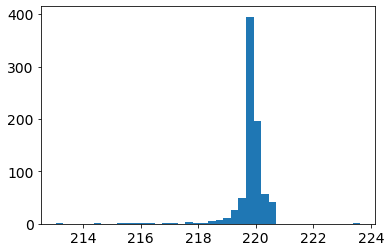

In [52]:
#Quick check (longer one would use bootstrap - do later ~~~!!!)
N = len(soil_site_data_mass_all)
N_range = np.arange(0, N, 1)
SSd = soil_site_data_mass_all.loc[:,['aggregated taxon','aggregated biome','mass_G']]

tot_soil_sens=np.zeros(N)

for ii in N_range:
    soil_biome_means_G_sens = SSd.loc[N_range!=ii].groupby(['aggregated taxon','aggregated biome'])['mass_G'].agg(np.mean).reset_index()
                          
    soil_biome_Mean_sens = soil_biome_means_G_sens.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_on='aggregated biome')
    tot_soil_sens[ii] = (soil_biome_Mean_sens.loc[:,'mass_G']*soil_biome_Mean_sens.loc[:,'area']).values.sum()/1e15 #total population per biome, in units of mg. (use 1e18 to convert to

plt.hist(tot_soil_sens,40)

#Removing a single site can result in up to 3% change in the final evaluation for soils
print('extreme upper change: ' + '{:.1f}'.format(100*(np.max(tot_soil_sens)-np.mean(tot_soil_sens))/np.mean(tot_soil_sens)) + '%')
print('extreme lower change: ' + '{:.1f}'.format(100*(np.mean(tot_soil_sens)-np.min(tot_soil_sens))/np.mean(tot_soil_sens)) + '%')

In [53]:
def filter_outliers(x):
    if len(x)>3:
        STD=x.std()
        Mean=np.mean(x)
        x = x[x<(Mean+2*STD)]
        x = x[x>(Mean-2*STD)]
    return x

def filter_outliers_log(x):
    if len(x)>3:
        X = np.log(x+0.01)
        STD=X.std()
        Mean=np.mean(X)
        x = x[X<(Mean+2*STD)]
        x = x[X>(Mean-2*STD)]
    return x

def filt_mean(x):
    return np.mean(filter_outliers_log(x))

soil_biome_means_G_outliers = SSd.groupby(['aggregated taxon','aggregated biome'])['mass_G'].agg([filt_mean]).reset_index()
#soil_biome_means_G_outliers.rename(columns={'filt_mean': 'Mean_Ar'}, inplace=True)
soil_biome_Mean_outliers = soil_biome_means_G_outliers.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_on='aggregated biome')
tot_soil_outliers = (soil_biome_Mean_outliers.loc[:,'filt_mean']*soil_biome_Mean_outliers.loc[:,'area']).sum()/1e15 #total population per biome, in units of mg.

tot_soil_outliers
    

207.73146104845844

In [54]:
#% change of removing all outliers
(soil_tots.Total.sum() - tot_soil_outliers)/soil_tots.Total.sum()

0.06290036050929577

In [55]:
#Calculate the percent difference between converting population to biomass on biome-level (_B) or global level (_G)
soil_means = soil_site_data_mass_all.groupby(['aggregated taxon','aggregated biome'])['mass_G','mass_B'].agg(np.mean)
tot_soil = soil_means.groupby(['aggregated biome']).sum().merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_on='aggregated biome')

print('The difference in total biomass between using global and biome-level convertions (from population to biomass) is:\n' +
    '%d' %((np.sum(tot_soil.mass_G*tot_soil.area)/np.sum(tot_soil.mass_B*tot_soil.area)-1)*100) +'%')

The difference in total biomass between using global and biome-level convertions (from population to biomass) is:
1%


/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [56]:
tot_soil_mass = soil_site_data_mass_all.groupby(['aggregated taxon','aggregated biome'])['mass density'].agg(np.mean).groupby(['aggregated biome']).sum().reset_index().merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_on='aggregated biome')
tot_soil_mass['mass density']/tot_soil.mass_G




0    1.062206
1    1.120462
2    2.190453
3    1.513800
4    0.975138
5    1.116438
6    1.061963
7    1.167372
8    1.027819
9    0.999271
dtype: float64

In [58]:
soil_site_Other = soil_site_data_mass_all[soil_site_data_mass_all['aggregated taxon'] == 'Other']
SP_soil_site_Other = soil_site_data_mass_all_SP[soil_site_data_mass_all_SP['aggregated taxon'] == 'Other']
SP_soil_site_Other.groupby(['aggregated biome'])['site'].count()

aggregated biome
Boreal Forests/Taiga                                             59
Crops                                                            47
Deserts and Xeric Shrublands                                      9
Mediterranean Forests, Woodlands and Scrub                       46
Pasture                                                          54
Temperate Forests                                               141
Temperate Grasslands, Savannas and Shrublands                    24
Tropical and Subtropical Forests                                 83
Tropical and Subtropical Grasslands, Savannas and Shrublands     16
Tundra                                                           26
Name: site, dtype: int64

In [59]:
SP_mean1 = soil_site_Other.groupby(['aggregated biome'])['mass_G'].mean()
SP_mean1

aggregated biome
Boreal Forests/Taiga                                            196.006599
Crops                                                           727.110714
Deserts and Xeric Shrublands                                      0.000000
Mediterranean Forests, Woodlands and Scrub                        0.000000
Pasture                                                         516.323448
Temperate Forests                                               779.588084
Temperate Grasslands, Savannas and Shrublands                   697.809003
Tropical and Subtropical Forests                                620.627025
Tropical and Subtropical Grasslands, Savannas and Shrublands    111.274585
Tundra                                                           50.028300
Name: mass_G, dtype: float64

In [61]:
SP_mean2 = SP_soil_site_Other.groupby(['sub-phylum','aggregated biome'])['mass_G'].mean().reset_index().groupby(['aggregated biome'])['mass_G'].sum()
SP_mean2/SP_mean1

aggregated biome
Boreal Forests/Taiga                                            1.157194
Crops                                                           1.215582
Deserts and Xeric Shrublands                                         NaN
Mediterranean Forests, Woodlands and Scrub                           NaN
Pasture                                                         1.458617
Temperate Forests                                               1.322769
Temperate Grasslands, Savannas and Shrublands                   2.084887
Tropical and Subtropical Forests                                1.241986
Tropical and Subtropical Grasslands, Savannas and Shrublands    1.835196
Tundra                                                          2.278667
Name: mass_G, dtype: float64

## Combine figures for paper

### Figure 2 (soil densities)

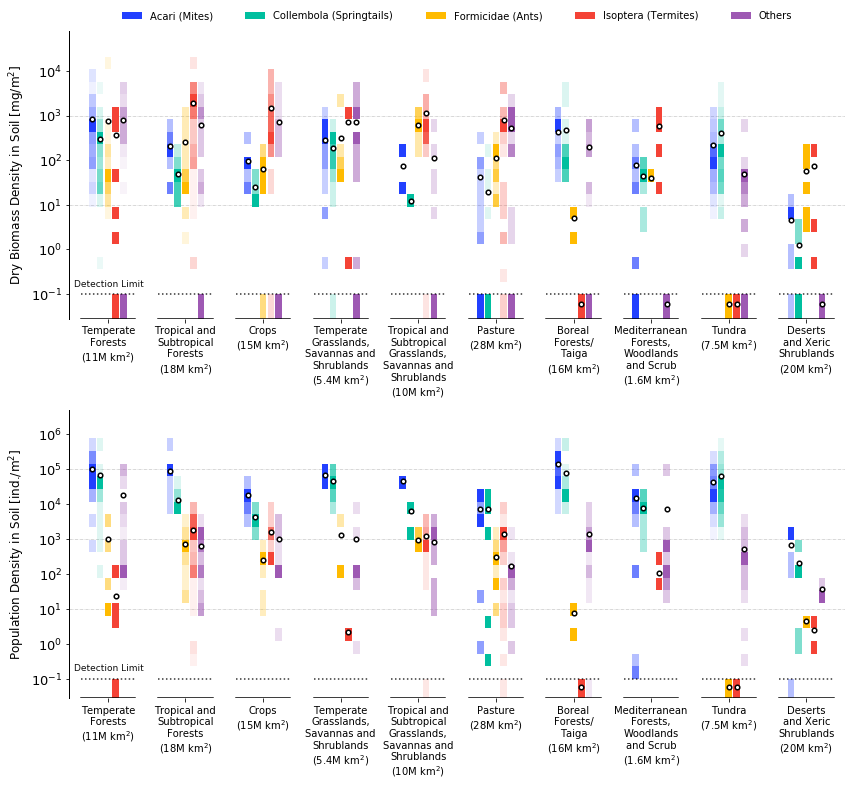

In [125]:
def print_data(x,ax):
    col_map = pd.Series(col_arr,index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r['aggregated biome'].unique()),2),index=r['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
    ax.set_yscale('symlog',linthreshy=0.1)
        
def print_bootstrap(x):
    locs = pd.Series(range(0,2*len(r['aggregated biome'].unique()),2),index=r['aggregated biome'].unique())
    x = x.replace(to_replace=original_biomes,value=print_biomes)
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = x['mean']+0.08
    L = x['2.5%']
    U = x['97.5%']
    plt.scatter(x=xloc,y= Y,marker='o' ,facecolors='w',edgecolors='k', alpha=1,s=21,linewidths=1.5,zorder=3)  #~~~###~~~Change etc. 

fig,ax=plt.subplots(2,1,figsize=[12,11])

fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])

ax1 = plt.subplot(2,1,1)

for i in range(0,2*len(r['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)    #plot dotted lines for breaking points "detection limit"

#Plot data
t_norm.groupby(['aggregated biome','aggregated taxon','level_2']).apply(lambda x: print_data(x,ax=ax1)) #plot bins
#ax1 = plt.gca()
ax1.plot([-1,19],[10,10],'k-.',alpha=0.3,linewidth=0.5,zorder=0) #plot grid lines
ax1.plot([-1,19],[1000,1000],'k-.',alpha=0.3,linewidth=0.5,zorder=0) #plot grid lines
ax1.set_xticks(range(0,2*len(r['aggregated biome'].unique()),2)) 
ax1.set_xticklabels(r['aggregated biome'].unique(),fontdict={'size':10})
ax1.get_label()
ax1.set_ylabel('Dry Biomass Density in Soil [mg/m$^2$]',fontdict={'size':12})
ax1.set_ylim([0.05,0.8e5])
ax1.set_xlim([-1,19])
legend_without_duplicate_labels(ax1,(0.5,1.1)) #lower left 0.007 (0.01,0.9)
sb.despine(top=True, bottom=True, right=True)

soil_Stats.reset_index().groupby(['aggregated biome','aggregated taxon']).apply(print_bootstrap)###

ax1.text(0.007, 0.135, 'Detection Limit', transform=ax1.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)

ax2 = plt.subplot(2,1,2)

for i in range(0,2*len(r_pop['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)    #plot dotted lines for breaking points "detection limit"

#Plot data
t_norm_pop.groupby(['aggregated biome','aggregated taxon','level_2']).apply(lambda x: print_data(x,ax=ax2))
#ax2 = plt.gca()
ax2.plot([-1,19],[1e1,1e1],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax2.plot([-1,19],[1e3,1e3],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax2.plot([-1,19],[1e5,1e5],'k-.',alpha=0.3,linewidth=0.5,zorder=0)
ax2.set_xticks(range(0,2*len(r['aggregated biome'].unique()),2))
ax2.set_xticklabels(r['aggregated biome'].unique(),fontdict={'size':10})
ax2.get_label()
ax2.set_ylabel('Population Density in Soil [ind./m$^2$]',fontdict={'size':12})
ax2.set_ylim([0.05,5e6])
ax2.set_xlim([-1,19])
#legend_without_duplicate_labels(ax2,(0.5,1.03)) #lower left 0.007 (0.01,0.9)
sb.despine(top=True, bottom=True, right=True)
soil_pop_Stats.reset_index().groupby(['aggregated biome','aggregated taxon']).apply(print_bootstrap)###

ax2.text(0.007, 0.12, 'Detection Limit', transform=ax2.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)

#ax1.text(-0.06,1.035,'A',fontdict={'size':20},transform = ax1.transAxes)
#ax2.text(-0.06,1,'B',fontdict={'size':20},transform = ax2.transAxes)

plt.tight_layout()

if save_bool:
    plt.savefig('results/figs/Soil densities (fig2).pdf',dpi=300)
else:
    plt.show()

### Figure 3 (biomass and population global distributions and total by biome)

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


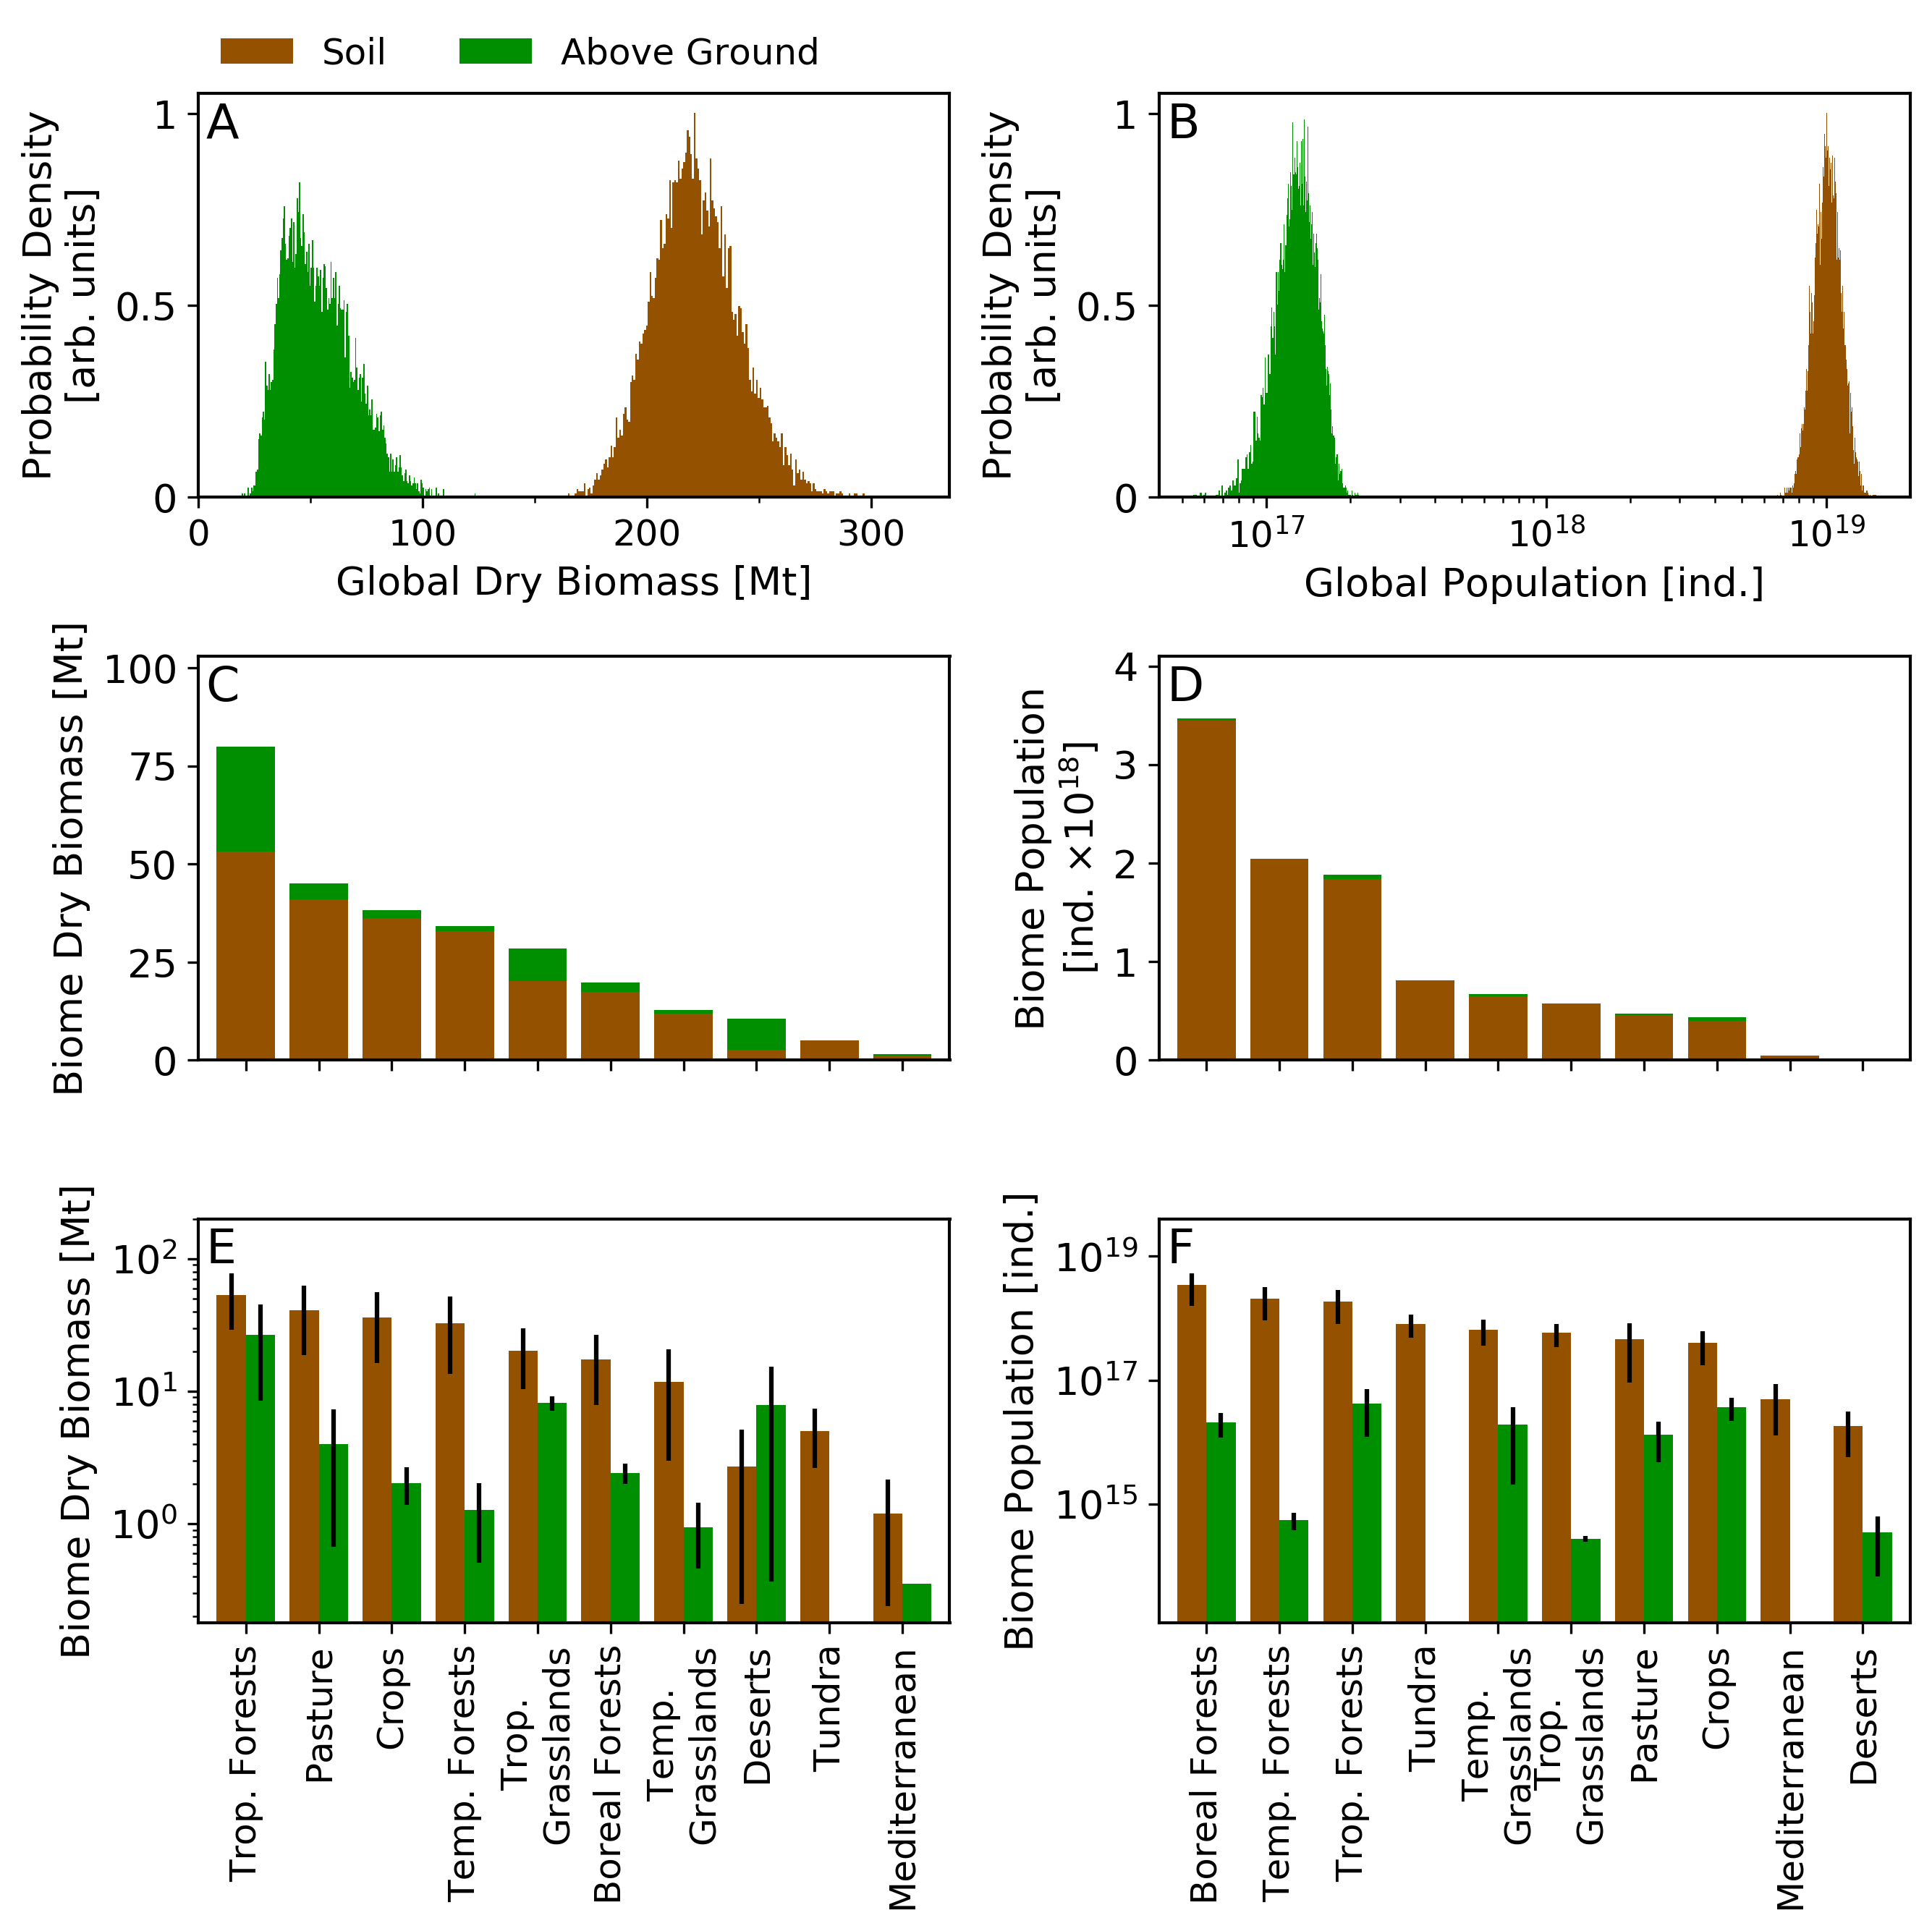

In [177]:
fig,ax = plt.subplots(3,2,figsize=[9,9],dpi=300)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=13)

xlabel_size = 13 #xlabel font size
ylabel_size = 13 #ylabel font size
letter_size = 16 #letter font size

ax1 = plt.subplot(3,2,1)

plt.hist(soil_Overall_tots,bins=200,alpha=1, color=Habitat_Color[0])
plt.hist(above_ground_Overall_tots,bins=200,alpha=1, color=Habitat_Color[2])

plt.xlabel('Global Dry Biomass [Mt]',size = xlabel_size)
plt.ylabel('Probability Density\n[arb. units]',size = ylabel_size)

ax1.xaxis.set_ticks([0,100,200,300])
ax1.xaxis.set_minor_locator(MultipleLocator(50))
mx=ax1.get_ylim()[1]*0.95 
ax1.yaxis.set_ticks([0, mx/2, mx])
ax1.yaxis.set_ticklabels([0, 0.5, 1])
ax1.text(0.01,0.89,'A',fontdict={'size':letter_size},transform = ax1.transAxes)

plt.legend(['Soil','Above Ground'],frameon=False,loc=[0.01,1.02],ncol=2,fontsize=12)


ax2 = plt.subplot(3,2,2)

plt.hist(soil_pop_Overall_tots*1e18,bins=200,alpha=1, color=Habitat_Color[0])
plt.hist(above_ground_pop_Overall_tots*1e18,bins=200,alpha=1, color=Habitat_Color[2])

plt.xscale('log')
plt.xlabel('Global Population [ind.]',size = xlabel_size)
plt.ylabel('Probability Density\n[arb. units]',size = ylabel_size)


mx=ax2.get_ylim()[1]*0.95
ax2.yaxis.set_ticks([0, mx/2, mx])
ax2.yaxis.set_ticklabels([0, 0.5, 1])
ax2.text(0.01,0.89,'B',fontdict={'size':letter_size},transform = ax2.transAxes)

#plt.legend(['Soil','Above Ground'],frameon=False,loc='upper center').set_visible(False) 


#Plot biomass and population data per biomeand habitat type (environment)
col_env = [Habitat_Color[0],Habitat_Color[2]]#colors of the environments
#plt.rcParams.update({'font.size': 12}) #increase the font size here

ax3 = plt.subplot(3,2,3)
mass_tots.plot.bar(width = 0.8, color=col_env,ax=ax3,logy=False,stacked=True,legend=False,use_index=False)
ax3.set_ylabel('Biome Dry Biomass [Mt]',size = ylabel_size)
ax3.xaxis.set_ticklabels([''])
ax3.set_ylim([0,103])
ax3.text(0.01,0.89,'C',fontdict={'size':letter_size},transform = ax3.transAxes)

ax4 = plt.subplot(3,2,4)
(pop_tots/1e18).plot.bar(width = 0.8, color=col_env,ax=ax4,logy=False,stacked=True,legend=False,use_index=False)
ax4.set_ylabel('Biome Population\n' + r'[ind. $\times 10^{18}$]',size = ylabel_size)
ax4.xaxis.set_ticklabels([''])
ax4.set_ylim([0,4.1])
ax4.text(0.01,0.89,'D',fontdict={'size':letter_size},transform = ax4.transAxes)


ax5 = plt.subplot(3,2,5)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=col_env,ax=ax5,logy=True,stacked=False,rot=90,legend=False)
ax5.set_ylabel('Biome Dry Biomass [Mt]',size = ylabel_size)
ax5.xaxis.label.set_visible(False)
ax5.set_ylim([0,200])
ax5.text(0.01,0.89,'E',fontdict={'size':letter_size},transform = ax5.transAxes)

ax6 = plt.subplot(3,2,6)
pop_tots.plot.bar(yerr=err_p ,width = 0.8, color=col_env,ax=ax6,logy=True,stacked=False,rot=90,legend=False)
ax6.set_ylabel('Biome Population [ind.]',size = ylabel_size)
ax6.xaxis.label.set_visible(False)
ax6.set_ylim([1.2e13,4e19])
ax6.text(0.01,0.89,'F',fontdict={'size':letter_size},transform = ax6.transAxes)

plt.tight_layout()

if True:
    plt.savefig('results/figs/Global and biome level total estimates (fig3).pdf',dpi=300,transparent=True)
else:
    plt.show()

### Figure 4 (soil totals by taxon)

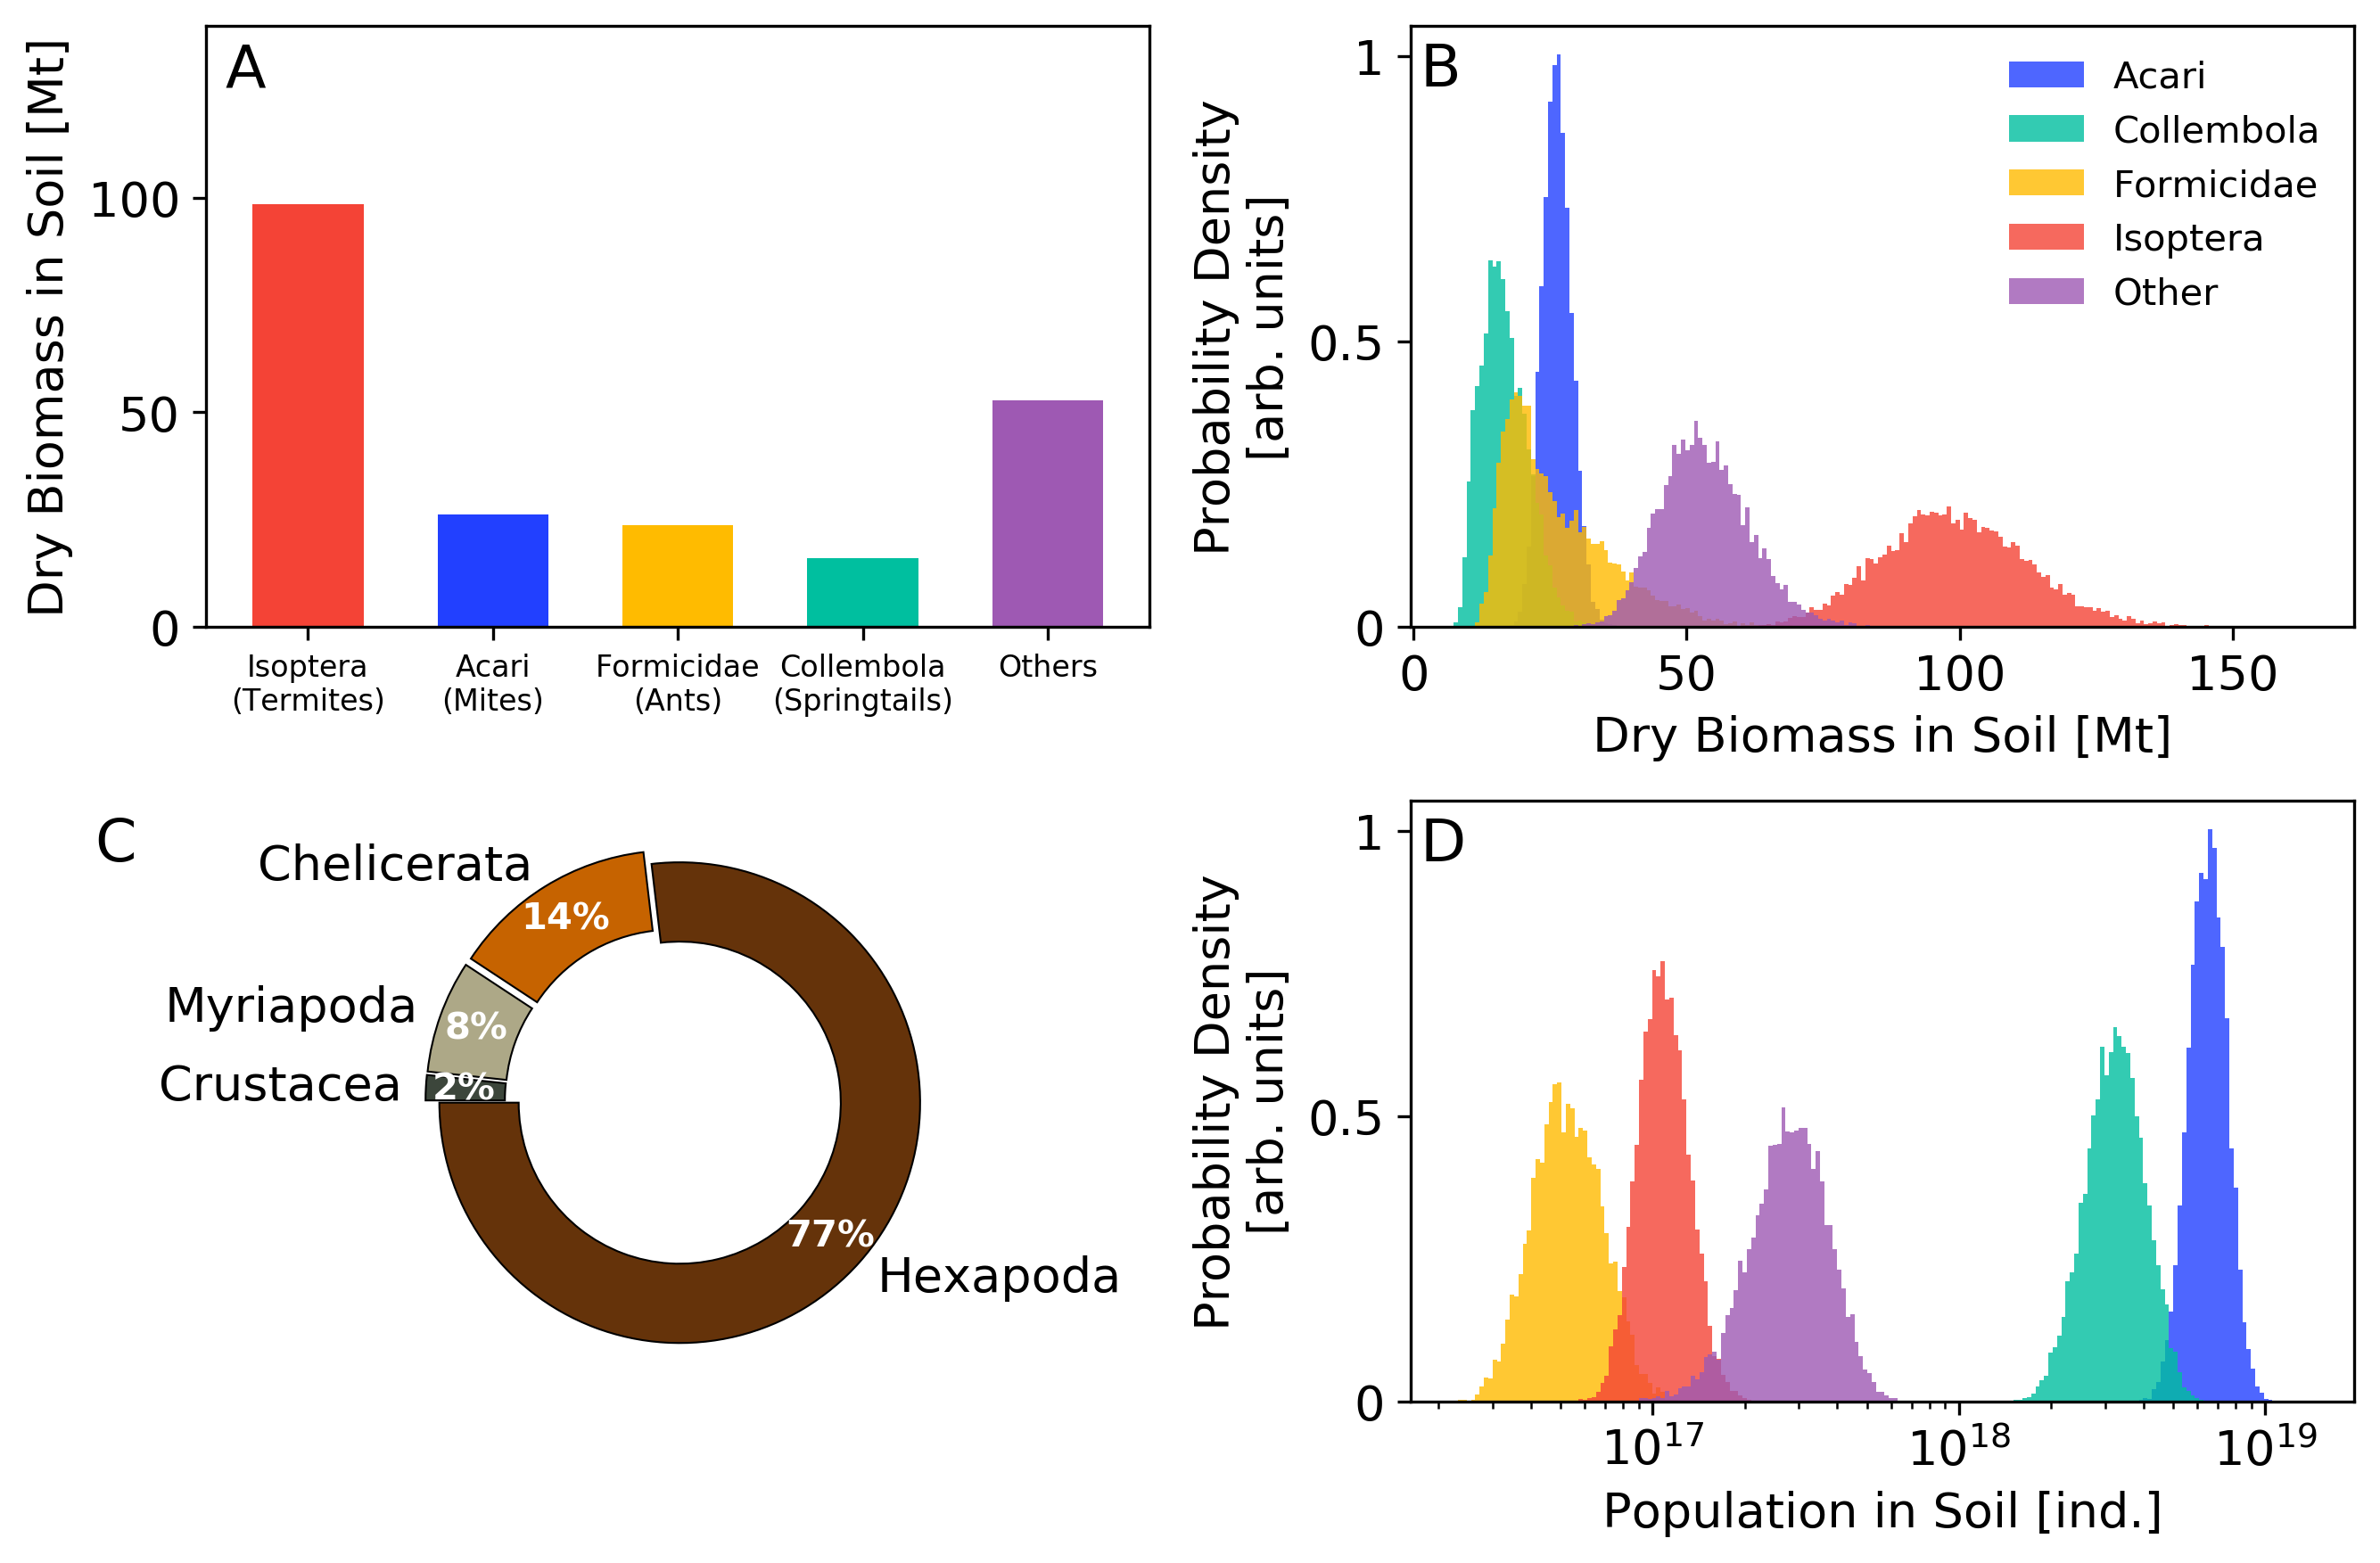

In [87]:
fig,ax = plt.subplots(2,2,figsize=[9,6],dpi=300)
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)

xlabel_size = 13 #xlabel font size
ylabel_size = 13 #ylabel font size
letter_size = 16 #letter font size

#plt.rcParams.update({'font.size': 12}) #increase the font size here
plt.rc('text', usetex=False)



#plt.rcParams.update({'font.size': 10}) #decrease back the font size here




#Biomass bars by taxon
ax1 = plt.subplot(2,2,1)

group_sum = tot_biomass_taxon.median()
group_colors = pd.Series(col_arr,index = group_sum.index)
new_index = ['Isoptera','Acari','Formicidae','Collembola','Other']
group_sum = group_sum.reindex(new_index)
group_colors = group_colors.reindex(new_index)

group_sum.index = ['Isoptera\n(Termites)','Acari\n(Mites)','Formicidae\n(Ants)','Collembola\n(Springtails)','Others']

group_colors.index = group_sum.index
group_sum.plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax1)
ax1.set_ylabel('Dry Biomass in Soil [Mt]',fontdict={'size':ylabel_size})
plt.xticks(fontsize=8)

ax1.set_ylim([0,140])
ax1.set(yticks=np.arange(0,140,50))

ax1.text(0.02,0.9,'A',fontdict={'size':letter_size},transform = ax1.transAxes)

#Biomass distribution by taxon
ax2 = plt.subplot(2,2,2)

tot_biomass_taxon.plot.hist(bins=200, ax=ax2, alpha=0.8,color=col_arr,log=False)

mx=ax2.get_ylim()[1]*0.95 #np.max(np.histogram(tot_biomass_taxon,bins=200)[0])*0.75
ax2.yaxis.set_ticks([0, mx/2, mx])
ax2.yaxis.set_ticklabels([0, 0.5, 1])
ax2.text(0.01,0.9,'B',fontdict={'size':letter_size},transform = ax2.transAxes)

plt.xlabel('Dry Biomass in Soil [Mt]',size = xlabel_size)
plt.ylabel('Probability Density\n[arb. units]',size = ylabel_size)
ax2.legend(title='',frameon=False)

#Biomass percentage by sub-phyla
ax3 = plt.subplot(2,2,3)

subphyla_sum = SP_tot.sort_values(ascending=False)
labels = subphyla_sum.index


patches, texts, pcts = ax3.pie(
    subphyla_sum, labels=labels, 
    colors=['#65330A', '#C66300','#ADA887','#3C463B'],
    autopct='%1.0f%%',pctdistance=0.84,textprops={'color':"k"},
    wedgeprops={'width':0.33,'edgecolor':'black', 'linewidth':0.5},
    startangle=180,explode = (0.01, 0.05, 0.05, 0.05))

# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold')

ax3.text(-0.47,0.9,'C',fontdict={'size':letter_size},transform = ax3.transAxes)


#Population distribution by taxon
ax4 = plt.subplot(2,2,4)

tot_taxon_pop.plot.hist(bins=np.logspace(16.35,19.15, 200),ax=ax4, alpha=0.8,color=col_arr)
plt.gca().set_xscale("log")

plt.xlabel('Population in Soil [ind.]',size = xlabel_size)
plt.ylabel('Probability Density\n[arb. units]',size = ylabel_size)

ax4.legend(title='',frameon=False,loc='upper center').set_visible(False)

mx=ax4.get_ylim()[1]*0.95#np.max(np.histogram(tot_taxon_pop,bins=np.logspace(16.35,19.15, 200))[0])#*0.61
ax4.yaxis.set_ticks([0, mx/2, mx])
ax4.yaxis.set_ticklabels([0, 0.5, 1])
ax4.text(0.01,0.9,'D',fontdict={'size':letter_size},transform = ax4.transAxes)

plt.tight_layout()

if save_bool:
    plt.savefig('results/figs/Soil taxonomic breakdown (fig4).pdf',dpi=300)
else:
    plt.show()



### Figure S5

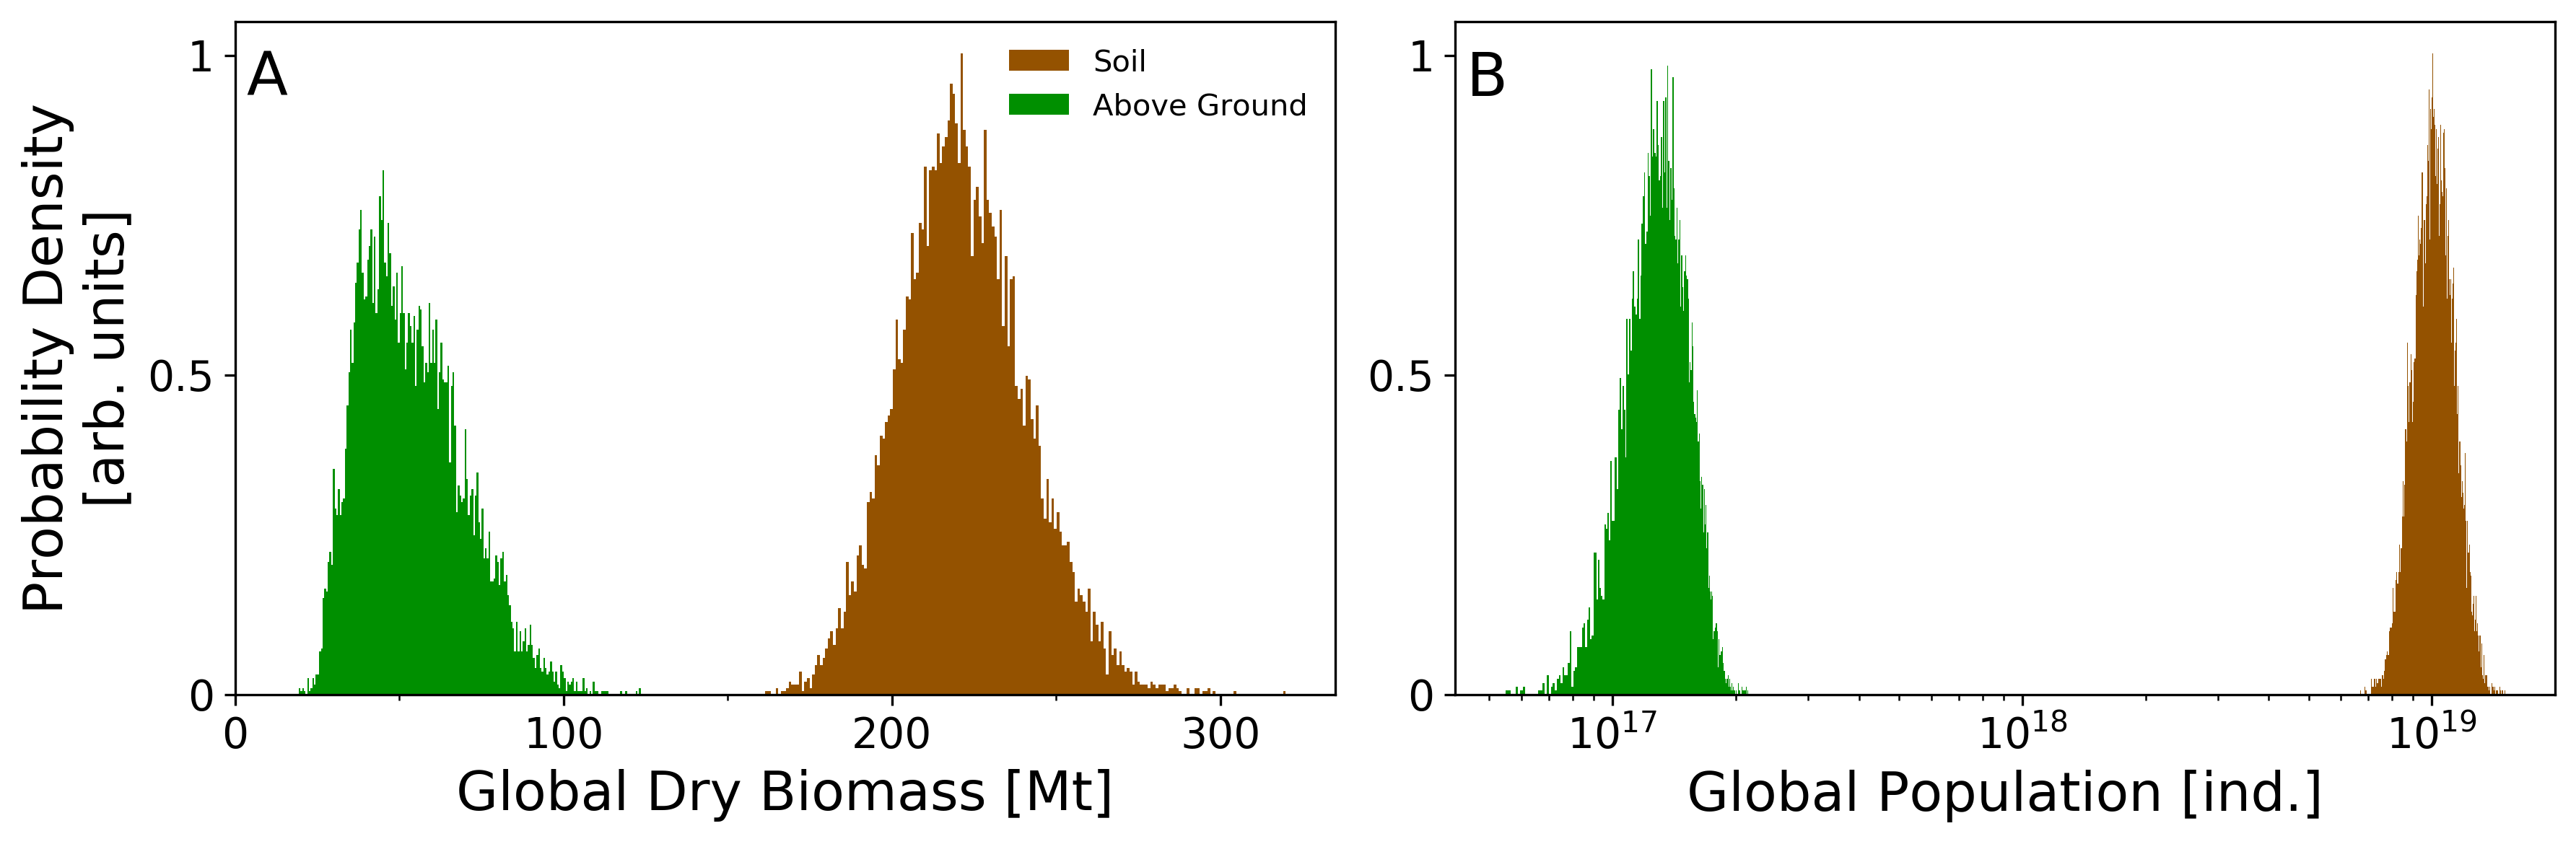

In [10]:
#Save plots.
fig,ax = plt.subplots(1,2,figsize=[12,4],dpi=300)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
xlabel_size = 18
ylabel_size = 18
letter_size = 20

ax1 = plt.subplot(1,2,1)

plt.hist(soil_Overall_tots,bins=200,alpha=1, color=Habitat_Color[0])
plt.hist(above_ground_Overall_tots,bins=200,alpha=1, color=Habitat_Color[2])

plt.xlabel('Global Dry Biomass [Mt]',size = xlabel_size)
plt.ylabel('Probability Density\n[arb. units]',size = ylabel_size)

ax1.xaxis.set_ticks([0,100,200,300])
ax1.xaxis.set_minor_locator(MultipleLocator(50))
mx=ax1.get_ylim()[1]*0.95 
ax1.yaxis.set_ticks([0, mx/2, mx])
ax1.yaxis.set_ticklabels([0, 0.5, 1])
ax1.text(0.01,0.89,'A',fontdict={'size':letter_size},transform = ax1.transAxes)

#plt.legend(['Soil','Above Ground'],frameon=False,loc=[0.01,1.02],ncol=2,fontsize=12)
plt.legend(['Soil','Above Ground'],frameon=False)

ax2 = plt.subplot(1,2,2)

plt.hist(soil_pop_Overall_tots*1e18,bins=200,alpha=1, color=Habitat_Color[0])
plt.hist(above_ground_pop_Overall_tots*1e18,bins=200,alpha=1, color=Habitat_Color[2])

plt.xscale('log')
plt.xlabel('Global Population [ind.]',size = xlabel_size)
plt.ylabel('',size = ylabel_size)


mx=ax2.get_ylim()[1]*0.95
ax2.yaxis.set_ticks([0, mx/2, mx])
ax2.yaxis.set_ticklabels([0, 0.5, 1])
ax2.text(0.01,0.89,'B',fontdict={'size':letter_size},transform = ax2.transAxes)

plt.tight_layout()
if save_bool:
    plt.savefig('results/figs/S5 - Global biomass distributions.pdf',dpi=300)
else: 
    plt.show()


fig,ax = plt.subplots(3,2,figsize=[12,12],dpi=300)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

ax = plt.subplot(3,2,1)

plot_biomass_comb(soil_Overall_tots,color=Habitat_Color[0])
plot_biomass_comb(above_ground_Overall_tots,color=Habitat_Color[2])

mx=ax.get_ylim()[1]*0.95 #np.max(np.histogram(above_ground_Overall_tots,bins=200)[0])
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'A',fontdict={'size':20},transform = ax.transAxes)

plt.legend(['Soil','Above-ground'],frameon=True,loc='upper right')

ax = plt.subplot(3,2,3)

plot_taxa_biomass(tot_biomass_taxon, ax=ax, xlabel = 'Dry Biomass in Soil [Mt]', ylabel='' , save_bool = False , filename='Soil Dry Biomass (taxa)')
#tot_biomass_taxon.plot.hist(bins=200, ax=ax, alpha=0.8,color=col_arr)

ax.legend(title='',frameon=False)

mx=ax.get_ylim()[1]*0.95 #np.max(np.histogram(tot_biomass_taxon,bins=200)[0])*0.75
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'C',fontdict={'size':20},transform = ax.transAxes)

ax = plt.subplot(3,2,2)

plot_biomass_comb(soil_pop_Overall_tots*1e18,xlabel = 'Population [ind]', color=Habitat_Color[0],log=True,alpha=1)
plot_biomass_comb(above_ground_pop_Overall_tots*1e18,xlabel = 'Population [ind.]',color=Habitat_Color[2],log=True,alpha=1)

mx=ax.get_ylim()[1]*0.95#np.max(np.histogram(above_ground_pop_Overall_tots,bins=200)[0])
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'B',fontdict={'size':20},transform = ax.transAxes)

plt.legend(['Soil','Above-ground'],frameon=False,loc='upper center').set_visible(False) #loc=[0.08,0.84])


ax = plt.subplot(3,2,4)

tot_taxon_pop.plot.hist(bins=np.logspace(16.35,19.15, 200),ax=ax, alpha=0.8,color=col_arr)
plt.gca().set_xscale("log")

plt.xlabel('Soil Population [ind.]',size = 18)
plt.ylabel('',size = 18)

ax.legend(title='',frameon=False,loc='upper center').set_visible(False)

mx=ax.get_ylim()[1]*0.95#np.max(np.histogram(tot_taxon_pop,bins=np.logspace(16.35,19.15, 200))[0])#*0.61
ax.yaxis.set_ticks([0, mx/2, mx])
ax.yaxis.set_ticklabels([0, 0.5, 1])
ax.text(0.01,0.9,'D',fontdict={'size':20},transform = ax.transAxes)

plt.tight_layout()
plt.savefig('results/figs/test_all_distributions.pdf',dpi=300)
#plt.show()

#if save_bool:
#    plt.savefig('results/figs/Habitats_population.pdf',dpi=300)
#else:
#    plt.show()




In [ ]:
lknlkj #error break

In [179]:
#Save global variables:
#import dill  
#filename = 'tmp/globalsave_4_10_2021.pkl'
#dill.dump_session(filename)

#Load with: dill.load_session(filename)

In [2]:
#Load
import dill  
filename = 'tmp/globalsave_4_10_2021.pkl'
dill.load_session(filename)